### <a style="color:blue;">Data Analysis</a>

#### <a style="color:blue;">Import libraries and dataset</a>

In [ ]:
#%pip install panda
#%pip install matplotlib
#%pip install panda
#%pip install pycountry
#%pip install langdetect
#%pip install transformers
#
#%pip install seaborn
#%pip install LabelEncoder
#%pip install scikit-learn
#
#%pip install nltk
#%pip install wordcloud 
#
#%pip install joblib
#%pip install torch

In [1]:
# Libraries 

import pandas as pd
import numpy as np
import csv
import os
import time
import pycountry as pcty
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
import re
import torch
import string
import nltk

from joblib import parallel_backend
from langdetect import detect
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, recall_score, precision_score
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer

from nltk.sentiment import SentimentIntensityAnalyzer
from transformers import RobertaTokenizer, RobertaModel

from wordcloud import WordCloud, STOPWORDS


In [27]:
# Import dataset 
filename = 'tripadvisor-hotelreviewwithID.csv' #'tripadvisor-hotelreview.csv'  'tripadvisor-hotelreview-v2.csv'

if os.path.exists(filename):
    dataset = pd.read_csv(filename)

#### <a style="color:blue;">Dataset Overview</a>

In [30]:
# Dataset Overview
print ("Total rows & columns: " , dataset.shape, '\n') 
dataset.info()
dataset.describe()

Total rows & columns:  (64583, 22) 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 64583 entries, 0 to 64582
Data columns (total 22 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   id                    64583 non-null  int64  
 1   hotelname             64583 non-null  object 
 2   comment_count         64583 non-null  object 
 3   rating                64583 non-null  float64
 4   rating_word           64583 non-null  object 
 5   location_rating       64583 non-null  object 
 6   cleanliness_rating    64583 non-null  object 
 7   service_rating        64583 non-null  object 
 8   value_rating          64583 non-null  object 
 9   username              64583 non-null  object 
 10  guestCountryOfOrigin  52637 non-null  object 
 11  contributes           61378 non-null  float64
 12  helpfulvotes_guest    49345 non-null  float64
 13  guest_rating_bubble   64583 non-null  object 
 14  review_title          64583 non-n

id        rating    contributes  helpfulvotes_guest  \
count  64583.000000  64583.000000   61378.000000        49345.000000   
mean   32292.000000      4.431964     161.815048           78.096565   
std    18643.650555      0.202051    1831.162582         1113.403244   
min        1.000000      4.000000       1.000000            1.000000   
25%    16146.500000      4.500000       6.000000            8.000000   
50%    32292.000000      4.500000      29.000000           32.000000   
75%    48437.500000      4.500000      98.000000           72.000000   
max    64583.000000      5.000000  211962.000000       142971.000000   

       helpfulvotes  
count   8545.000000  
mean       2.533411  
std        4.367278  
min        1.000000  
25%        1.000000  
50%        1.000000  
75%        3.000000  
max      189.000000

In [31]:
dataset.sample(5)

id                                    hotelname comment_count  \
29693  29694  InterContinental Kuala Lumpur, an IHG Hotel         3,844   
17198  17199                     Grand Hyatt Kuala Lumpur         5,462   
24959  24960                      Shangri-La Kuala Lumpur         8,548   
60915  60916                 Pullman Kuala Lumpur Bangsar         1,716   
42837  42838                      The Westin Kuala Lumpur         3,694   

       rating rating_word             location_rating  \
29693     4.5   Excellent  ui_bubble_rating bubble_45   
17198     4.5   Excellent  ui_bubble_rating bubble_50   
24959     4.5   Excellent  ui_bubble_rating bubble_45   
60915     4.0   Very good  ui_bubble_rating bubble_35   
42837     4.5   Excellent  ui_bubble_rating bubble_50   

               cleanliness_rating              service_rating  \
29693  ui_bubble_rating bubble_45  ui_bubble_rating bubble_45   
17198  ui_bubble_rating bubble_45  ui_bubble_rating bubble_45   
24959  ui_bubble_rating bubble_45  ui_bubble_rating bubble_45   
60915  ui_bubble_rating bubble_45  ui_bubble_rating bubble_40   
42837  ui_bubble_rating bubble_45  ui_bubble_rating bubble_45   

                     value_rating         username  ... helpfulvotes_guest  \
29693  ui_bubble_rating bubble_40     Sara Alsaleh  ...               10.0   
17198  ui_bubble_rating bubble_45         Andre758  ...               69.0   
24959  ui_bubble_rating bubble_45       Catherin O  ...                2.0   
60915  ui_bubble_rating bubble_40  matthewsB9939TA  ...                NaN   
42837  ui_bubble_rating bubble_40    Konstantina K  ...               42.0   

              guest_rating_bubble                  review_title  \
29693  ui_bubble_rating bubble_40             Client relations    
17198  ui_bubble_rating bubble_50                   outstanding   
24959  ui_bubble_rating bubble_50  Very good hotel and services   
60915  ui_bubble_rating bubble_40                     Good Stay   
42837  ui_bubble_rating bubble_50    Excellent room and service   

                                                  review      dateofStay  \
29693  Jason at the serena brasserie - such a funny g...      March 2016   
17198  Business visit for three nights. Nothing left ...   November 2017   
24959  Im one of regular guest of shangrila, they hav...   December 2013   
60915  Good Hotel, great staff chearful happy and pos...    October 2014   
42837  Very comfortable, big rooms with a nice view. ...     August 2016   

      trip_type helpfulvotes rooms_rate  cleanliness_rate service_rate  
29693       NaN          NaN        NaN               NaN          NaN  
17198       NaN          NaN        NaN               NaN          NaN  
24959       NaN          NaN        NaN               NaN          NaN  
60915       NaN          NaN        NaN               NaN          NaN  
42837       NaN          NaN        NaN               NaN          NaN  

[5 rows x 22 columns]

In [5]:
dataset.describe()

id        rating    contributes  helpfulvotes_guest  \
count  64583.000000  64583.000000   61378.000000        49345.000000   
mean   32292.000000      4.431964     161.815048           78.096565   
std    18643.650555      0.202051    1831.162582         1113.403244   
min        1.000000      4.000000       1.000000            1.000000   
25%    16146.500000      4.500000       6.000000            8.000000   
50%    32292.000000      4.500000      29.000000           32.000000   
75%    48437.500000      4.500000      98.000000           72.000000   
max    64583.000000      5.000000  211962.000000       142971.000000   

       helpfulvotes  
count   8545.000000  
mean       2.533411  
std        4.367278  
min        1.000000  
25%        1.000000  
50%        1.000000  
75%        3.000000  
max      189.000000

In [6]:
# df = dataset[~dataset.username.isna()]
# df = dataset[dataset.hotelname!='Ascott Kuala Lumpur']
# df.shape

# df.to_csv('tripadvisor-hotelreview-v2-clean.csv',index=False)



### <a style="color:blue;"> Data Pre-processing</a>

#### Merge review_title and review columns:

In [34]:
dataset['review'] = dataset['review_title'].str.cat(dataset['review'], sep='. ')

In [35]:
dataset.drop(["review_title"],axis=1, inplace=True)

In [36]:
dataset.sample(5)

id                                    hotelname comment_count  \
50500  50501              The Majestic Hotel Kuala Lumpur         3,523   
9644    9645                            8 Kia Peng Suites           157   
39887  39888               The Ritz-Carlton, Kuala Lumpur         1,934   
28065  28066  InterContinental Kuala Lumpur, an IHG Hotel         3,844   
7350    7351                          Hilton Kuala Lumpur         6,421   

       rating rating_word             location_rating  \
50500     4.5   Excellent  ui_bubble_rating bubble_40   
9644      4.5   Excellent  ui_bubble_rating bubble_40   
39887     4.5   Excellent  ui_bubble_rating bubble_50   
28065     4.5   Excellent  ui_bubble_rating bubble_45   
7350      4.5   Excellent  ui_bubble_rating bubble_45   

               cleanliness_rating              service_rating  \
50500  ui_bubble_rating bubble_50  ui_bubble_rating bubble_45   
9644   ui_bubble_rating bubble_40  ui_bubble_rating bubble_50   
39887  ui_bubble_rating bubble_45  ui_bubble_rating bubble_45   
28065  ui_bubble_rating bubble_45  ui_bubble_rating bubble_45   
7350   ui_bubble_rating bubble_45  ui_bubble_rating bubble_45   

                     value_rating       username  ... contributes  \
50500  ui_bubble_rating bubble_45    hzulkarnain  ...        13.0   
9644   ui_bubble_rating bubble_50  kellymira8218  ...         NaN   
39887  ui_bubble_rating bubble_45      Shahriman  ...         3.0   
28065  ui_bubble_rating bubble_40         alia j  ...         NaN   
7350   ui_bubble_rating bubble_45          Almas  ...        14.0   

       helpfulvotes_guest         guest_rating_bubble  \
50500                 5.0  ui_bubble_rating bubble_50   
9644                  NaN  ui_bubble_rating bubble_50   
39887                 NaN  ui_bubble_rating bubble_50   
28065                 NaN  ui_bubble_rating bubble_50   
7350                  NaN  ui_bubble_rating bubble_50   

                                                  review      dateofStay  \
50500  A luxurious friendly hotel. The YTL Leadership...   November 2014   
9644   4D3N Staycation. Love the hotel so much, clean...      April 2022   
39887  A memorable stay at The Ritz-Carlton KL.. Step...   December 2022   
28065  Great stay!. Had the best time in ICKL! We sta...        May 2022   
7350   Excellent stay. Had visited the Hilton in Kual...     August 2010   

                   trip_type helpfulvotes  rooms_rate cleanliness_rate  \
50500                    NaN          NaN         NaN              NaN   
9644                     NaN          NaN         NaN              NaN   
39887  Travelled with family          NaN         NaN              NaN   
28065                    NaN          NaN         NaN              NaN   
7350                     NaN          NaN         NaN              NaN   

      service_rate  
50500          NaN  
9644           NaN  
39887          NaN  
28065          NaN  
7350           NaN  

[5 rows x 21 columns]

In [37]:
reviews = dataset['review']
reviews

0        Lovely Experience in Iconic EQ KL Hotel. I spe...
1        Truly a world class hotel. Stayed here for two...
2        A Gem in the Heart of the Golden Triangle. EQ ...
3        Super location great hotel”. Very accommodatin...
4        EQ KL. Excellent service and Japanese restaura...
                               ...                        
64578    Please improve on the small details and servic...
64579    Luxurious!. Stayed 2 nights with my family of ...
64580    Fantastic place to stay in KL!. Spent 3 days i...
64581    Still green. Must give time for them to improv...
64582    A great base for families. As a family of four...
Name: review, Length: 64583, dtype: object

#### Remove non-English reviews:

In [38]:
start_time = time.time()
# filter rows with english reviews only
#with parallel_backend('multiprocessing'):
dataset_filter =  dataset[dataset.review.apply(detect).eq('en')]

end_time = time.time()
time_taken = end_time - start_time
print(f"Time taken: {time_taken} seconds")

Time taken: 470.2174837589264 seconds


In [39]:
print ("Total rows & columns of english reviews: " , dataset_filter.shape, '\n') 
dataset_filter.sample(3)

Total rows & columns of english reviews:  (64079, 21) 



id                        hotelname comment_count  rating  \
22283  22284          Shangri-La Kuala Lumpur         8,548     4.5   
50644  50645  The Majestic Hotel Kuala Lumpur         3,523     4.5   
8429    8430  Four Seasons Hotel Kuala Lumpur         1,073     4.5   

      rating_word             location_rating          cleanliness_rating  \
22283   Excellent  ui_bubble_rating bubble_45  ui_bubble_rating bubble_45   
50644   Excellent  ui_bubble_rating bubble_40  ui_bubble_rating bubble_50   
8429    Excellent  ui_bubble_rating bubble_50  ui_bubble_rating bubble_50   

                   service_rating                value_rating      username  \
22283  ui_bubble_rating bubble_45  ui_bubble_rating bubble_45      Pinkie S   
50644  ui_bubble_rating bubble_45  ui_bubble_rating bubble_45  Dr Nazurah P   
8429   ui_bubble_rating bubble_45  ui_bubble_rating bubble_45        T2Kmum   

       ... contributes  helpfulvotes_guest         guest_rating_bubble  \
22283  ...         1.0                 NaN  ui_bubble_rating bubble_50   
50644  ...        12.0                 NaN  ui_bubble_rating bubble_50   
8429   ...        26.0                39.0  ui_bubble_rating bubble_50   

                                                  review   dateofStay  \
22283  Reeza and Sarah' Wedding Reception . May 14, 2...     May 2016   
50644  An excellent stay!!!. My husband and I chose t...    June 2014   
8429   A friendly luxurious oasis in a busy city . We...   April 2019   

      trip_type helpfulvotes  rooms_rate cleanliness_rate service_rate  
22283       NaN          NaN         NaN              NaN          NaN  
50644       NaN          NaN         NaN              NaN          NaN  
8429        NaN          3.0         NaN              NaN          NaN  

[3 rows x 21 columns]

In [40]:
# rows with non-english reviews
# df1[~df1.index.isin(df2.index)]
#df_foreign = dataset_filter[~dataset.index.isin(dataset_filter.index)]
df_foreign = dataset[~dataset.index.isin(dataset_filter.index)]
print ("Total rows & columns of non-english reviews: " , df_foreign.shape, '\n') 
df_foreign.review.sample(10)

Total rows & columns of non-english reviews:  (504, 21) 



51278    屋上のインフィニティ―プール最高. 屋上に宿泊者しか行けないインフィニティ―プールがあります...
51414    Хороший отель. В январе 2018 года были в Куала...
50999    Appartamenti di ottimo livello. Bellissimo ( e...
51090    Хорошо!. Сразу начну с заселения.  Заселение с...
51245    WAHNSINN. Die Unterkunft ist einfach genial. W...
51021    Hôtel où Airbnb ?. L'établissement est coupé e...
40234    バトラーさんのサービスが素晴らしいです。. I had a lot of work in m...
51856    Super po zwiedzanu miasta. Hotel należy do jed...
52000    Magnifique piscine à faire !!. L'hôtel dans so...
51551    Invinity pool luar biasa. Icon dari kuala lump...
Name: review, dtype: object

In [104]:
#backup original dataset before remove non-english reviews
### XXXX dataset_backup = dataset ###

#reset original dataset from backup
#dataset = dataset_backup
print ("dataset Total rows & columns: " , dataset.shape, '\n') 
print ("dataset_backup Total rows & columns: " , dataset_backup.shape, '\n') 

dataset Total rows & columns:  (64583, 21) 

dataset_backup Total rows & columns:  (64583, 21) 



In [105]:
# set filter dataset to main dataframe
dataset = dataset_filter
print ("Total rows & columns: " , dataset.shape, '\n') 

Total rows & columns:  (64079, 22) 



In [73]:
print ("dataset Total rows & columns: " , dataset.shape, '\n') 
print ("dataset_filter Total rows & columns: " , dataset_filter.shape, '\n') 

dataset Total rows & columns:  (64079, 22) 

dataset_filter Total rows & columns:  (64079, 22) 



#### Remove reviews of less than 5 words:

In [106]:
# count review len
dataset['review_len'] = dataset['review'].str.split().str.len()
# [len(x.split()) for x in dataset['review'].tolist()]

C:\Users\wan24\AppData\Local\Temp\ipykernel_11236\4027175212.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset['review_len'] = dataset['review'].str.split().str.len()


In [107]:
dataset_5 = dataset[dataset['review_len'] <= 5]

#no reviews with < 5 words found

In [108]:
dataset_5.shape

(11, 22)

In [77]:
dataset_5['review']

16240    Excellent service and facilities. #NAME?
29452                Classic elegant room. #NAME?
35269               Business travel to KL. #NAME?
39348                          short stay. #NAME?
39783                          Staycation. #NAME?
44966                          Nice hotel. #NAME?
50250               Luxury Business Hotel. #NAME?
51121                        Middle of KL. #NAME?
57206           Warm and Friendly Service. #NAME?
58544                 Not clean, bad food. #NAME?
62450       Informal, not very hospitable. #NAME?
Name: review, dtype: object

In [109]:
#drop reviews with <= 5 words 
dataset = dataset[dataset['review'].apply(lambda x: len(x.split())) > 5]

In [110]:
print ("dataset Total rows & columns: " , dataset.shape) 

dataset Total rows & columns:  (64068, 22)


In [111]:
dataset.drop(["review_len"],axis=1, inplace=True)


C:\Users\wan24\anaconda3\lib\site-packages\pandas\core\frame.py:4308: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


#### Drop high null value count columns:

In [81]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 64068 entries, 0 to 64582
Data columns (total 21 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   id                    64068 non-null  int64  
 1   hotelname             64068 non-null  object 
 2   comment_count         64068 non-null  object 
 3   rating                64068 non-null  float64
 4   rating_word           64068 non-null  object 
 5   location_rating       64068 non-null  object 
 6   cleanliness_rating    64068 non-null  object 
 7   service_rating        64068 non-null  object 
 8   value_rating          64068 non-null  object 
 9   username              64068 non-null  object 
 10  guestCountryOfOrigin  52232 non-null  object 
 11  contributes           60881 non-null  float64
 12  helpfulvotes_guest    48958 non-null  float64
 13  guest_rating_bubble   64068 non-null  object 
 14  review                64068 non-null  object 
 15  dateofStay         

In [82]:
#Missing values in dataset
print ("\nMissing values: ", dataset.isnull().sum().values.sum())

#Missing values details
percent_missing = dataset.isnull().sum() * 100 / len(dataset)
missing_values = pd.DataFrame({'column_name': dataset.columns,'percent_missing': percent_missing})
missing_values.sort_values('percent_missing', ascending = False, inplace=True)
print ("\nMissing values for each variables: ", missing_values)


Missing values:  341509

Missing values for each variables:                                 column_name  percent_missing
service_rate                  service_rate        99.801773
cleanliness_rate          cleanliness_rate        99.795530
rooms_rate                      rooms_rate        99.792408
trip_type                        trip_type        99.667541
helpfulvotes                  helpfulvotes        86.743772
helpfulvotes_guest      helpfulvotes_guest        23.584317
guestCountryOfOrigin  guestCountryOfOrigin        18.474121
contributes                    contributes         4.974402
dateofStay                      dateofStay         0.207592
service_rating              service_rating         0.000000
value_rating                  value_rating         0.000000
username                          username         0.000000
hotelname                        hotelname         0.000000
cleanliness_rating      cleanliness_rating         0.000000
guest_rating_bubble    guest_rating_bu

In [112]:
# drop columns "trip_type","rooms_rate", "cleanliness_rate","service_rate"
# 99% of missing value, can ignore these columns
dataset.drop(["trip_type","rooms_rate", "cleanliness_rate","service_rate","helpfulvotes"],axis=1, inplace=True)
dataset.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 64068 entries, 0 to 64582
Data columns (total 16 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   id                    64068 non-null  int64  
 1   hotelname             64068 non-null  object 
 2   comment_count         64068 non-null  object 
 3   rating                64068 non-null  float64
 4   rating_word           64068 non-null  object 
 5   location_rating       64068 non-null  object 
 6   cleanliness_rating    64068 non-null  object 
 7   service_rating        64068 non-null  object 
 8   value_rating          64068 non-null  object 
 9   username              64068 non-null  object 
 10  guestCountryOfOrigin  52232 non-null  object 
 11  contributes           60881 non-null  float64
 12  helpfulvotes_guest    48958 non-null  float64
 13  guest_rating_bubble   64068 non-null  object 
 14  review                64068 non-null  object 
 15  dateofStay         

#### Imputation of guest country of origin:

In [84]:
dataset[['guestCountryOfOrigin']].sample(10)

guestCountryOfOrigin
33748                       NaN
63818                       NaN
63821              Muscat, Oman
58124          Hong Kong, China
9743                        NaN
15343      Singapore, Singapore
31989       Paarl, South Africa
63155      Singapore, Singapore
49475  Barnsley, United Kingdom
64323          Hong Kong, China

In [113]:
# define function to extract country name from guestOriginLocation column

def getCountry (guestOriginLocation):
    try:
      for country in pcty.countries:
        if country.name in guestOriginLocation:
            return country.name
    except:
        return guestOriginLocation


In [114]:
dataset['guestCountry'] = dataset.apply(lambda dataset: getCountry(dataset['guestCountryOfOrigin']),axis=1)

C:\Users\wan24\AppData\Local\Temp\ipykernel_11236\705919501.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset['guestCountry'] = dataset.apply(lambda dataset: getCountry(dataset['guestCountryOfOrigin']),axis=1)


In [58]:
dataset[['guestCountryOfOrigin','guestCountry']].sample(10)

guestCountryOfOrigin    guestCountry
44915                     NaN             NaN
27126  Kendal, United Kingdom  United Kingdom
56118    Singapore, Singapore       Singapore
62078    Singapore, Singapore       Singapore
32599        Perth, Australia       Australia
44579        Hong Kong, China           China
32268                 mirissa            None
17808       Kuching, Malaysia        Malaysia
26317   Nashua, New Hampshire            None
22802         Porto, Portugal        Portugal

#### Proper rating imputation

In [59]:
# clean data, impute data with proper rating
all_bubble_rating = dataset[['location_rating','cleanliness_rating','service_rating','value_rating','guest_rating_bubble']]
all_bubble_rating.sample(5)

location_rating          cleanliness_rating  \
49691  ui_bubble_rating bubble_40  ui_bubble_rating bubble_50   
56483  ui_bubble_rating bubble_45  ui_bubble_rating bubble_40   
57815  ui_bubble_rating bubble_45  ui_bubble_rating bubble_45   
5049   ui_bubble_rating bubble_45  ui_bubble_rating bubble_45   
26085  ui_bubble_rating bubble_45  ui_bubble_rating bubble_45   

                   service_rating                value_rating  \
49691  ui_bubble_rating bubble_45  ui_bubble_rating bubble_45   
56483  ui_bubble_rating bubble_40  ui_bubble_rating bubble_40   
57815  ui_bubble_rating bubble_40  ui_bubble_rating bubble_45   
5049   ui_bubble_rating bubble_45  ui_bubble_rating bubble_45   
26085  ui_bubble_rating bubble_45  ui_bubble_rating bubble_45   

              guest_rating_bubble  
49691  ui_bubble_rating bubble_50  
56483  ui_bubble_rating bubble_40  
57815  ui_bubble_rating bubble_50  
5049   ui_bubble_rating bubble_30  
26085  ui_bubble_rating bubble_40

In [115]:
# 
dataset.location_rating = (dataset.location_rating.str.extract('(\d+)').astype(int))/10
dataset.cleanliness_rating = (dataset.cleanliness_rating.str.extract('(\d+)').astype(int))/10
dataset.service_rating = (dataset.service_rating.str.extract('(\d+)').astype(int))/10
dataset.value_rating = (dataset.value_rating.str.extract('(\d+)').astype(int))/10
dataset.guest_rating_bubble = (dataset.guest_rating_bubble.str.extract('(\d+)').astype(int))/10


C:\Users\wan24\anaconda3\lib\site-packages\pandas\core\generic.py:5494: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


In [61]:
dataset[['location_rating','cleanliness_rating','service_rating','value_rating','guest_rating_bubble']].sample(5)

location_rating  cleanliness_rating  service_rating  value_rating  \
42168              5.0                 4.5             4.5           4.0   
50582              4.0                 5.0             4.5           4.5   
37918              4.0                 4.5             4.5           4.5   
43181              5.0                 4.5             4.5           4.0   
17756              5.0                 4.5             4.5           4.5   

       guest_rating_bubble  
42168                  5.0  
50582                  5.0  
37918                  4.0  
43181                  4.0  
17756                  5.0

In [88]:
dataset.describe()

id        rating  location_rating  cleanliness_rating  \
count  64068.000000  64068.000000     64068.000000        64068.000000   
mean   32156.310779      4.431432         4.660564            4.492453   
std    18640.112843      0.202736         0.364100            0.251025   
min        1.000000      4.000000         3.500000            4.000000   
25%    16031.750000      4.500000         4.500000            4.500000   
50%    32062.500000      4.500000         4.500000            4.500000   
75%    48093.250000      4.500000         5.000000            4.500000   
max    64583.000000      5.000000         5.000000            5.000000   

       service_rating  value_rating    contributes  helpfulvotes_guest  \
count    64068.000000  64068.000000   60881.000000        48958.000000   
mean         4.421419      4.314330     161.770602           78.234834   
std          0.235018      0.252529    1838.221180         1117.742617   
min          4.000000      4.000000       1.000000            1.000000   
25%          4.500000      4.000000       6.000000            8.000000   
50%          4.500000      4.500000      29.000000           32.000000   
75%          4.500000      4.500000      98.000000           72.000000   
max          5.000000      5.000000  211962.000000       142971.000000   

       guest_rating_bubble  
count         64068.000000  
mean              4.434273  
std               0.930593  
min               1.000000  
25%               4.000000  
50%               5.000000  
75%               5.000000  
max               5.000000

In [90]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 64068 entries, 0 to 64582
Data columns (total 17 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   id                    64068 non-null  int64  
 1   hotelname             64068 non-null  object 
 2   comment_count         64068 non-null  object 
 3   rating                64068 non-null  float64
 4   rating_word           64068 non-null  object 
 5   location_rating       64068 non-null  float64
 6   cleanliness_rating    64068 non-null  float64
 7   service_rating        64068 non-null  float64
 8   value_rating          64068 non-null  float64
 9   username              64068 non-null  object 
 10  guestCountryOfOrigin  52232 non-null  object 
 11  contributes           60881 non-null  float64
 12  helpfulvotes_guest    48958 non-null  float64
 13  guest_rating_bubble   64068 non-null  float64
 14  review                64068 non-null  object 
 15  dateofStay         

#### Drop columns not in used

In [116]:
#Drop column "id","username","guestCountryOfOrigin"
dataset.drop(["username","guestCountryOfOrigin"],axis=1, inplace=True)


#### Missing Values Imputation

In [92]:
#Missing values in dataset
print ("\nMissing values: ", dataset.isnull().sum().values.sum())

#Missing values details
percent_missing = dataset.isnull().sum() * 100 / len(dataset)
missing_values = pd.DataFrame({'column_name': dataset.columns,'percent_missing': percent_missing})
missing_values.sort_values('percent_missing', ascending = False, inplace=True)
print ("\nMissing values for each variables: ", missing_values)


Missing values:  39801

Missing values for each variables:                               column_name  percent_missing
guestCountry                guestCountry        33.356746
helpfulvotes_guest    helpfulvotes_guest        23.584317
contributes                  contributes         4.974402
dateofStay                    dateofStay         0.207592
id                                    id         0.000000
hotelname                      hotelname         0.000000
comment_count              comment_count         0.000000
rating                            rating         0.000000
rating_word                  rating_word         0.000000
location_rating          location_rating         0.000000
cleanliness_rating    cleanliness_rating         0.000000
service_rating            service_rating         0.000000
value_rating                value_rating         0.000000
guest_rating_bubble  guest_rating_bubble         0.000000
review                            review         0.000000


In [117]:
dataset["guestCountry"] = dataset["guestCountry"].fillna("Not Mentioned")

C:\Users\wan24\AppData\Local\Temp\ipykernel_11236\3679778226.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset["guestCountry"] = dataset["guestCountry"].fillna("Not Mentioned")


In [118]:
dataset["contributes"] = dataset["contributes"].fillna(0)
dataset["helpfulvotes_guest"] = dataset["helpfulvotes_guest"].fillna(0)
dataset["dateofStay"] = dataset["dateofStay"].fillna(0)

C:\Users\wan24\AppData\Local\Temp\ipykernel_11236\1897117628.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset["contributes"] = dataset["contributes"].fillna(0)
C:\Users\wan24\AppData\Local\Temp\ipykernel_11236\1897117628.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset["helpfulvotes_guest"] = dataset["helpfulvotes_guest"].fillna(0)
C:\Users\wan24\AppData\Local\Temp\ipykernel_11236\1897117628.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFram

In [65]:
#dataset = dataset.fillna(99999)

In [119]:
dataset[["guestCountry","helpfulvotes_guest","contributes","dateofStay"]] 

guestCountry  helpfulvotes_guest  contributes      dateofStay
0      Not Mentioned                 0.0          0.0    January 2023
1      Not Mentioned                 0.0          0.0    January 2023
2          Singapore                78.0        105.0    January 2023
3      Not Mentioned                 0.0          0.0   December 2022
4      Not Mentioned                 0.0          0.0    January 2023
...              ...                 ...          ...             ...
64578       Malaysia                22.0         40.0   February 2013
64579      Australia                28.0         12.0    January 2013
64580      Sri Lanka                 0.0          2.0    January 2013
64581       Thailand                 6.0         20.0   December 2012
64582  Not Mentioned                 0.0         34.0   December 2012

[64068 rows x 4 columns]

In [120]:
#Missing values in dataset
print ("\nMissing values: ", dataset.isnull().sum().values.sum())

#Missing values details
percent_missing = dataset.isnull().sum() * 100 / len(dataset)
missing_values = pd.DataFrame({'column_name': dataset.columns,'percent_missing': percent_missing})
missing_values.sort_values('percent_missing', ascending = False, inplace=True)
print ("\nMissing values for each variables: ", missing_values)


Missing values:  0

Missing values for each variables:                               column_name  percent_missing
id                                    id              0.0
hotelname                      hotelname              0.0
comment_count              comment_count              0.0
rating                            rating              0.0
rating_word                  rating_word              0.0
location_rating          location_rating              0.0
cleanliness_rating    cleanliness_rating              0.0
service_rating            service_rating              0.0
value_rating                value_rating              0.0
contributes                  contributes              0.0
helpfulvotes_guest    helpfulvotes_guest              0.0
guest_rating_bubble  guest_rating_bubble              0.0
review                            review              0.0
dateofStay                    dateofStay              0.0
guestCountry                guestCountry              0.0


#### Convert Data Type:

In [121]:
dataset['comment_count'] = dataset['comment_count'].str.replace(',', '')
dataset['comment_count'] = dataset['comment_count'].astype(int)

C:\Users\wan24\AppData\Local\Temp\ipykernel_11236\2520633775.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset['comment_count'] = dataset['comment_count'].str.replace(',', '')
C:\Users\wan24\AppData\Local\Temp\ipykernel_11236\2520633775.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset['comment_count'] = dataset['comment_count'].astype(int)


In [122]:
dataset['rating_word'].value_counts()

Excellent    53806
Very good    10262
Name: rating_word, dtype: int64

#### Label Encoding

In [123]:
# Encode rating_word labels
label_map = {'Excellent': 2, 'Very good': 1}
dataset['rating_word'] = dataset['rating_word'].apply(lambda x: label_map[x])

C:\Users\wan24\AppData\Local\Temp\ipykernel_11236\2644944212.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset['rating_word'] = dataset['rating_word'].apply(lambda x: label_map[x])


In [124]:
dataset['rating'].value_counts()

4.5    52330
4.0    10262
5.0     1476
Name: rating, dtype: int64

In [125]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 64068 entries, 0 to 64582
Data columns (total 15 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   id                   64068 non-null  int64  
 1   hotelname            64068 non-null  object 
 2   comment_count        64068 non-null  int32  
 3   rating               64068 non-null  float64
 4   rating_word          64068 non-null  int64  
 5   location_rating      64068 non-null  float64
 6   cleanliness_rating   64068 non-null  float64
 7   service_rating       64068 non-null  float64
 8   value_rating         64068 non-null  float64
 9   contributes          64068 non-null  float64
 10  helpfulvotes_guest   64068 non-null  float64
 11  guest_rating_bubble  64068 non-null  float64
 12  review               64068 non-null  object 
 13  dateofStay           64068 non-null  object 
 14  guestCountry         64068 non-null  object 
dtypes: float64(8), int32(1), int64(2), o

In [126]:
dataset.select_dtypes(include=['object'])

hotelname  \
0                  EQ Kuala Lumpur   
1                  EQ Kuala Lumpur   
2                  EQ Kuala Lumpur   
3                  EQ Kuala Lumpur   
4                  EQ Kuala Lumpur   
...                            ...   
64578  E&O Residences Kuala Lumpur   
64579  E&O Residences Kuala Lumpur   
64580  E&O Residences Kuala Lumpur   
64581  E&O Residences Kuala Lumpur   
64582  E&O Residences Kuala Lumpur   

                                                  review      dateofStay  \
0      Lovely Experience in Iconic EQ KL Hotel. I spe...    January 2023   
1      Truly a world class hotel. Stayed here for two...    January 2023   
2      A Gem in the Heart of the Golden Triangle. EQ ...    January 2023   
3      Super location great hotel”. Very accommodatin...   December 2022   
4      EQ KL. Excellent service and Japanese restaura...    January 2023   
...                                                  ...             ...   
64578  Please improve on the small details and servic...   February 2013   
64579  Luxurious!. Stayed 2 nights with my family of ...    January 2013   
64580  Fantastic place to stay in KL!. Spent 3 days i...    January 2013   
64581  Still green. Must give time for them to improv...   December 2012   
64582  A great base for families. As a family of four...   December 2012   

        guestCountry  
0      Not Mentioned  
1      Not Mentioned  
2          Singapore  
3      Not Mentioned  
4      Not Mentioned  
...              ...  
64578       Malaysia  
64579      Australia  
64580      Sri Lanka  
64581       Thailand  
64582  Not Mentioned  

[64068 rows x 4 columns]

In [127]:
dataset["hotelname"] = dataset["hotelname"].astype('category')
dataset["hotelname_encode"] = dataset["hotelname"].cat.codes

C:\Users\wan24\AppData\Local\Temp\ipykernel_11236\4107274076.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset["hotelname"] = dataset["hotelname"].astype('category')
C:\Users\wan24\AppData\Local\Temp\ipykernel_11236\4107274076.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset["hotelname_encode"] = dataset["hotelname"].cat.codes


In [128]:
def dateofStay_encoding(dateofStay):
    out = ''
    m = {
         'jan': '01',
         'feb': '02',
         'mar': '03',
         'apr': '04',
         'may': '05',
         'jun': '06',
         'jul': '07',
         'aug': '08',
         'sep': '09',
         'oct': '10',
         'nov': '11',
         'dec': '12'
        }
    try:
        if dateofStay != "":
            s = dateofStay.strip()[:3].lower()
            year = dateofStay.strip()[-4:].lower()
        
            out = m[s]+year
            return out
    except:
            return dateofStay

In [367]:
#dataframe column month date (e.g. January 2021) convert to number 012021

#dateofStay_encoding('January 2021')

'012021'

In [129]:
dataset['dateofStay_encode'] = dataset.apply(lambda dataset: dateofStay_encoding(dataset['dateofStay']),axis=1)

C:\Users\wan24\AppData\Local\Temp\ipykernel_11236\2990582755.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset['dateofStay_encode'] = dataset.apply(lambda dataset: dateofStay_encoding(dataset['dateofStay']),axis=1)


In [130]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 64068 entries, 0 to 64582
Data columns (total 17 columns):
 #   Column               Non-Null Count  Dtype   
---  ------               --------------  -----   
 0   id                   64068 non-null  int64   
 1   hotelname            64068 non-null  category
 2   comment_count        64068 non-null  int32   
 3   rating               64068 non-null  float64 
 4   rating_word          64068 non-null  int64   
 5   location_rating      64068 non-null  float64 
 6   cleanliness_rating   64068 non-null  float64 
 7   service_rating       64068 non-null  float64 
 8   value_rating         64068 non-null  float64 
 9   contributes          64068 non-null  float64 
 10  helpfulvotes_guest   64068 non-null  float64 
 11  guest_rating_bubble  64068 non-null  float64 
 12  review               64068 non-null  object  
 13  dateofStay           64068 non-null  object  
 14  guestCountry         64068 non-null  object  
 15  hotelname_encode   

In [131]:
dataset["guestCountry"] = dataset["guestCountry"].astype('category')
dataset["guestCountry_encode"] = dataset["guestCountry"].cat.codes

C:\Users\wan24\AppData\Local\Temp\ipykernel_11236\539627738.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset["guestCountry"] = dataset["guestCountry"].astype('category')
C:\Users\wan24\AppData\Local\Temp\ipykernel_11236\539627738.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset["guestCountry_encode"] = dataset["guestCountry"].cat.codes


In [132]:
dataset['guestCountry_encode'].value_counts()

105    21371
84      8827
142     7066
9       6363
123     6097
       ...  
16         1
47         1
139        1
12         1
0          1
Name: guestCountry_encode, Length: 150, dtype: int64

In [133]:
dataset.sample(10)

id                                    hotelname  comment_count  \
59284  59285                   Royale Chulan Kuala Lumpur           2860   
64054  64055                  E&O Residences Kuala Lumpur            946   
31642  31643              Mandarin Oriental, Kuala Lumpur           7269   
28362  28363  InterContinental Kuala Lumpur, an IHG Hotel           3844   
1431    1432       Lanson Place Bukit Ceylon Kuala Lumpur           1064   
1703    1704                     Banyan Tree Kuala Lumpur            839   
35760  35761              Mandarin Oriental, Kuala Lumpur           7269   
24574  24575                      Shangri-La Kuala Lumpur           8548   
33252  33253              Mandarin Oriental, Kuala Lumpur           7269   
26413  26414                      Shangri-La Kuala Lumpur           8548   

       rating  rating_word  location_rating  cleanliness_rating  \
59284     4.5            2              4.5                 4.5   
64054     4.0            1              4.5                 4.0   
31642     4.5            2              5.0                 4.5   
28362     4.5            2              4.5                 4.5   
1431      5.0            2              5.0                 5.0   
1703      4.5            2              5.0                 4.5   
35760     4.5            2              5.0                 4.5   
24574     4.5            2              4.5                 4.5   
33252     4.5            2              5.0                 4.5   
26413     4.5            2              4.5                 4.5   

       service_rating  value_rating  contributes  helpfulvotes_guest  \
59284             4.0           4.5        290.0               310.0   
64054             4.0           4.0          3.0                 0.0   
31642             4.5           4.5         21.0                25.0   
28362             4.5           4.0         50.0                 0.0   
1431              4.5           4.5         86.0                37.0   
1703              4.5           4.5          1.0                 4.0   
35760             4.5           4.5         41.0                15.0   
24574             4.5           4.5        136.0                96.0   
33252             4.5           4.5          1.0                 0.0   
26413             4.5           4.5        134.0               129.0   

       guest_rating_bubble                                             review  \
59284                  2.0  4* at the most. Was given an "upgrade" upon ch...   
64054                  5.0  E&O PERFECT Residences. Stayed 4 nights in Aug...   
31642                  1.0  Good but not excellent. Checked in here this t...   
28362                  5.0  Wonder stay. . I had an absolutely wonderful s...   
1431                   5.0  Great stay in a great location!. We had a  ver...   
1703                   5.0  Banyan Tree KL is the best hotel!. Everything ...   
35760                  5.0  Omg! Best hotel I ever stayed in!. I was given...   
24574                  5.0  Unreal breakfasts!. Great hotel, spacious, mod...   
33252                  4.0  Very good. Property was well located in the he...   
26413                  5.0  True 5 star luxury. Great location close to th...   

           dateofStay   guestCountry  hotelname_encode dateofStay_encode  \
59284   November 2011        Germany                19            112011   
64054     August 2017      Australia                 4            082017   
31642   November 2021       Malaysia                14            112021   
28362    October 2019  Not Mentioned                10            102019   
1431    December 2014  Not Mentioned                12            122014   
1703    December 2020       Malaysia                 3            122020   
35760   December 2013  Not Mentioned                14            122013   
24574   December 2013        Ireland                20            122013   
33252   November 2017  Not Mentioned                14            

In [ ]:
#export preprocessed dataset to csv - before labelling
dataset.to_csv('dataset_preprocessed-b4TextPr.csv',index=False)

In [ ]:
# ***** import dataset_preprocessed instead of re-run the code ***** 
filename = 'dataset_preprocessed-b4TextPr.csv' 

if os.path.exists(filename):
    dataset = pd.read_csv(filename)

### Text Pre-processing

In [134]:

nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\wan24\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\wan24\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\wan24\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [135]:
stop_words = set(stopwords.words("english"))
lemmatizer = WordNetLemmatizer()
def preprocess_text(text):
    # Lowercase
    text = text.lower()
    # Remove punctuation
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
    # Remove numbers
    text = re.sub('\d+', '', text)
    
    # Tokenize
    tokens = word_tokenize(text)
    
    #Remove stop words,Lemmatization
    tokens = [lemmatizer.lemmatize(token) for token in tokens if token not in stop_words and token.isalpha()]
    return " ".join(tokens)


In [136]:
start_time = time.time()
dataset['review'] = dataset['review'].apply(preprocess_text)

end_time = time.time()
time_taken = end_time - start_time
print(f"Time taken: {time_taken} seconds")

Time taken: 46.378698110580444 seconds


C:\Users\wan24\AppData\Local\Temp\ipykernel_11236\998450328.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset['review'] = dataset['review'].apply(preprocess_text)


In [137]:
dataset['review']

0        lovely experience iconic eq kl hotel spent lov...
1        truly world class hotel stayed two night taken...
2        gem heart golden triangle eq kl gem unbeatable...
3        super location great hotel accommodating staff...
4        eq kl excellent service japanese restaurant co...
                               ...                        
64578    please improve small detail service standard d...
64579    luxurious stayed night family booked bedroom a...
64580    fantastic place stay kl spent day kl stayed ne...
64581    still green must give time improve property ne...
64582    great base family family four two teenage daug...
Name: review, Length: 64068, dtype: object

In [138]:
example = dataset["review"][1000]
print(example)

absolutely loved stay fell love lanson place bukit ceylon gorgeous property enormous pool nice surroundings relax gym work importantly room pretty comfy wanted leave best breakfast highest floor th correct designed like living room style would live penthouse absolutely gorgeous loved much also pool table lounge area best view kuala lumpur thank lanson place making stay truely amazing


### BACKUP: export preprocessed dataset to csv - before labelling

In [139]:
#export preprocessed dataset to csv - before labelling
dataset.to_csv('dataset_preprocessed-new.csv',index=False)

In [26]:
# ***** import dataset_preprocessed instead of re-run the code ***** 
filename = 'dataset_preprocessed-new.csv' 

if os.path.exists(filename):
    dataset = pd.read_csv(filename)

# Polarity Labelling

In [140]:
from transformers import AutoTokenizer
from transformers import AutoModelForSequenceClassification
from scipy.special import softmax

MODEL = f"cardiffnlp/twitter-roberta-base-sentiment"
tokenizer = AutoTokenizer.from_pretrained(MODEL)
model = AutoModelForSequenceClassification.from_pretrained(MODEL)

#nltk.download('vader_lexicon')

sia = SentimentIntensityAnalyzer()

In [141]:
start_time = time.time()
def polarity_scores_roberta(x):
    encoded_text = tokenizer(x, return_tensors="pt")
    output = model(**encoded_text)
    scores = output[0][0].detach().numpy()
    scores = softmax(scores)

    scoresDict = {"roberta_neg":scores[0],
                 "roberta_neu":scores[1],
                 "roberta_pos":scores[2]}
    return scoresDict

end_time = time.time()
time_taken = end_time - start_time
print(f"Time taken: {time_taken} seconds")


Time taken: 0.0 seconds


In [142]:
#polarity score with VADER and RoBERTa

start_time = time.time()

result_vader = {}
result_roberta = {}
for i in range(dataset.shape[0]):
    try: 
        text = dataset.loc[i,"review"]
        iD = dataset.loc[i,"id"]
        vader_result = sia.polarity_scores(text)
        roberta_result = polarity_scores_roberta(text)
    
        vader_result_name = {}
        for key,value in vader_result.items():
            vader_result_name[f"vader_{key}"] = value
    
        total_scores_vader = {**vader_result_name}
        total_scores_roberta = {**roberta_result}


        result_vader[iD]= total_scores_vader
        result_roberta[iD]= total_scores_roberta
    except RuntimeError:
        print(f"Broke for id {iD}")
    except KeyError:
       # print(f"KeyError for id {iD}")
       continue

end_time = time.time()
time_taken = end_time - start_time
print(f"Time taken: {time_taken} seconds")

Broke for id 8369
Time taken: 9247.70932674408 seconds


## VADER Sentiment Analysis

In [2]:
# ***** import vader_dataset instead of re-run the code ***** skip the below code if the section
filename = 'vader_dataset.csv' 

if os.path.exists(filename):
    vader_dataset = pd.read_csv(filename)

In [144]:
#result_vader to dataframe
start_time = time.time()
result_vader_df = pd.DataFrame(result_vader).T.reset_index().rename(columns={"index":"id"})

end_time = time.time()
time_taken = end_time - start_time
print(f"Time taken: {time_taken} seconds")

Time taken: 9.068028688430786 seconds


In [145]:
result_vader_df.sample(10)

id  vader_neg  vader_neu  vader_pos  vader_compound
22111  22137      0.000      0.630      0.370          0.9807
7548    7553      0.033      0.687      0.280          0.9207
56416  56928      0.000      0.516      0.484          0.9818
24687  24715      0.068      0.450      0.482          0.9485
22161  22188      0.049      0.683      0.268          0.9153
31637  31667      0.041      0.518      0.441          0.9552
62866  63383      0.104      0.706      0.190          0.8020
10294  10306      0.059      0.547      0.394          0.9906
23221  23248      0.000      0.531      0.469          0.9741
61568  62084      0.022      0.653      0.325          0.9784

In [146]:
#merge vader result with main dataset
vader_dataset = pd.merge(result_vader_df, dataset, how="left", on="id")
vader_dataset


id  vader_neg  vader_neu  vader_pos  vader_compound  \
0          1      0.012      0.644      0.344          0.9877   
1          2      0.063      0.703      0.234          0.8720   
2          3      0.000      0.690      0.310          0.9834   
3          4      0.000      0.536      0.464          0.9883   
4          5      0.000      0.551      0.449          0.9577   
...      ...        ...        ...        ...             ...   
63547  64064      0.102      0.855      0.043         -0.4215   
63548  64065      0.449      0.551      0.000         -0.9788   
63549  64066      0.000      0.604      0.396          0.8957   
63550  64067      0.061      0.773      0.166          0.7957   
63551  64068      0.146      0.686      0.168          0.2649   

                         hotelname  comment_count  rating  rating_word  \
0                  EQ Kuala Lumpur            575     5.0            2   
1                  EQ Kuala Lumpur            575     5.0            2   
2                  EQ Kuala Lumpur            575     5.0            2   
3                  EQ Kuala Lumpur            575     5.0            2   
4                  EQ Kuala Lumpur            575     5.0            2   
...                            ...            ...     ...          ...   
63547  E&O Residences Kuala Lumpur            946     4.0            1   
63548  E&O Residences Kuala Lumpur            946     4.0            1   
63549  E&O Residences Kuala Lumpur            946     4.0            1   
63550  E&O Residences Kuala Lumpur            946     4.0            1   
63551  E&O Residences Kuala Lumpur            946     4.0            1   

       location_rating  ...  value_rating  contributes  helpfulvotes_guest  \
0                  5.0  ...           5.0          0.0                 0.0   
1                  5.0  ...           5.0          0.0                 0.0   
2                  5.0  ...           5.0        105.0                78.0   
3                  5.0  ...           5.0          0.0                 0.0   
4                  5.0  ...           5.0          0.0                 0.0   
...                ...  ...           ...          ...                 ...   
63547              4.5  ...           4.0          0.0                 0.0   
63548              4.5  ...           4.0          3.0                 0.0   
63549              4.5  ...           4.0         81.0                43.0   
63550              4.5  ...           4.0       3726.0               160.0   
63551              4.5  ...           4.0         58.0                20.0   

       guest_rating_bubble                                             review  \
0                      5.0  lovely experience iconic eq kl hotel spent lov...   
1                      5.0  truly world class hotel stayed two night taken...   
2                      5.0  gem heart golden triangle eq kl gem unbeatable...   
3                      5.0  super location great hotel accommodating staff...   
4                      5.0  eq kl excellent service japanese restaurant co...   
...                    ...                                                ...   
63547                  1.0  الفندق غير جيد الفطور اقل من عادي طابور عند ال...   
63548                  1.0  worst ever worst hotel resident ever life sinc...   
63549                  5.0  nice hotel apartment time kuala lumpur favorit...   
63550                  3.0  hygiene review wont totally aligned term score...   
63551                  3.0  except space everything else average average f...   

           dateofStay   guestCountry hotelname_encode dateofStay_encode  \
0        January 2023  Not Mentioned                5            012023   
1        January 2023  Not Mentioned                5            012023   
2        January 2023      Singapore                5            012023   
3       December 2022  Not Mentioned                5            122022   
4        January 2023  Not Mentioned                5  

In [147]:
def get_vader_polarity(compound):
    polarity = compound
    if polarity >= 0.05:
        return 'positive'
    elif polarity <= -0.05:
        return 'negative'
    else:
        return 'neutral'

In [148]:
vader_dataset.head()

id  vader_neg  vader_neu  vader_pos  vader_compound        hotelname  \
0   1      0.012      0.644      0.344          0.9877  EQ Kuala Lumpur   
1   2      0.063      0.703      0.234          0.8720  EQ Kuala Lumpur   
2   3      0.000      0.690      0.310          0.9834  EQ Kuala Lumpur   
3   4      0.000      0.536      0.464          0.9883  EQ Kuala Lumpur   
4   5      0.000      0.551      0.449          0.9577  EQ Kuala Lumpur   

   comment_count  rating  rating_word  location_rating  ...  value_rating  \
0            575     5.0            2              5.0  ...           5.0   
1            575     5.0            2              5.0  ...           5.0   
2            575     5.0            2              5.0  ...           5.0   
3            575     5.0            2              5.0  ...           5.0   
4            575     5.0            2              5.0  ...           5.0   

   contributes  helpfulvotes_guest  guest_rating_bubble  \
0          0.0                 0.0                  5.0   
1          0.0                 0.0                  5.0   
2        105.0                78.0                  5.0   
3          0.0                 0.0                  5.0   
4          0.0                 0.0                  5.0   

                                              review      dateofStay  \
0  lovely experience iconic eq kl hotel spent lov...    January 2023   
1  truly world class hotel stayed two night taken...    January 2023   
2  gem heart golden triangle eq kl gem unbeatable...    January 2023   
3  super location great hotel accommodating staff...   December 2022   
4  eq kl excellent service japanese restaurant co...    January 2023   

    guestCountry hotelname_encode dateofStay_encode  guestCountry_encode  
0  Not Mentioned                5            012023                  105  
1  Not Mentioned                5            012023                  105  
2      Singapore                5            012023                  123  
3  Not Mentioned                5            122022                  105  
4  Not Mentioned                5            012023                  105  

[5 rows x 22 columns]

In [149]:
#dataset['polarity_vader'] = dataset['review_process'].apply(get_polarity)
vader_dataset['polarity_vader'] = vader_dataset.apply(lambda vader_dataset: get_vader_polarity(vader_dataset['vader_compound']),axis=1)

In [150]:
vader_dataset.sample(5)

id  vader_neg  vader_neu  vader_pos  vader_compound  \
23506  23533      0.157      0.734      0.108         -0.1027   
28397  28426      0.033      0.549      0.418          0.9741   
1465    1467      0.000      0.767      0.233          0.9618   
18189  18211      0.000      0.302      0.698          0.9901   
5170    5175      0.000      0.796      0.204          0.8402   

                                         hotelname  comment_count  rating  \
23506                      Shangri-La Kuala Lumpur           8548     4.5   
28397  InterContinental Kuala Lumpur, an IHG Hotel           3844     4.5   
1465        Lanson Place Bukit Ceylon Kuala Lumpur           1064     5.0   
18189                     Grand Hyatt Kuala Lumpur           5462     4.5   
5170                           Hilton Kuala Lumpur           6421     4.5   

       rating_word  location_rating  ...  contributes  helpfulvotes_guest  \
23506            2              4.5  ...          1.0                 4.0   
28397            2              4.5  ...          4.0                 0.0   
1465             2              5.0  ...        177.0               129.0   
18189            2              5.0  ...          7.0                13.0   
5170             2              4.5  ...        151.0               159.0   

       guest_rating_bubble                                             review  \
23506                  1.0  front desk service poor service front desk eve...   
28397                  5.0  incredible hotel experience checkin checkout a...   
1465                   5.0  brilliant spent two week lanson place staying ...   
18189                  5.0  business trip fantastic hotel stunning room gr...   
5170                   4.0  exceeded expectation upgraded executive king r...   

            dateofStay    guestCountry hotelname_encode dateofStay_encode  \
23506    February 2015   Not Mentioned               20            022015   
28397   September 2019   Not Mentioned               10            092019   
1465      January 2014  United Kingdom               12            012014   
18189        June 2016   Not Mentioned                7            062016   
5170          May 2016       Australia                9            052016   

      guestCountry_encode  polarity_vader  
23506                 105        negative  
28397                 105        positive  
1465                  142        positive  
18189                 105        positive  
5170                    9        positive  

[5 rows x 23 columns]

In [172]:
vader_dataset[["vader_neg","vader_neu","vader_pos","vader_compound","polarity_vader"]].sample(5)

vader_neg  vader_neu  vader_pos  vader_compound polarity_vader
55890      0.043      0.621      0.336          0.9850       positive
56934      0.027      0.677      0.296          0.9782       positive
47966      0.180      0.735      0.085         -0.5198       negative
57437      0.083      0.714      0.204          0.8885       positive
57239      0.025      0.624      0.351          0.9872       positive

In [173]:
# BACKUP: export merged vader dataset to csv
vader_dataset.to_csv('vader_dataset.csv',index=False)

In [174]:
vader_dataset['polarity_vader'].value_counts()        

positive    60969
negative     2360
neutral       223
Name: polarity_vader, dtype: int64

In [175]:
vader_positive = vader_dataset[vader_dataset["polarity_vader"]=="positive"]
vader_positive.shape

(60969, 23)

In [176]:
# plot the WordCloud image for Guest Reviews
start_time = time.time()
comment_words = ''
stopwords = set(STOPWORDS)
 
# iterate through the csv file
for val in vader_positive.review:
     
    # typecaste each val to string
    val = str(val)
 
    # split the value
    tokens = val.split()
     
    # Converts each token into lowercase
    for i in range(len(tokens)):
        tokens[i] = tokens[i].lower()
     
    comment_words += " ".join(tokens)+" "
 
wordcloud = WordCloud(width = 800, height = 800,
                background_color ='white',
                stopwords = stopwords,
                min_font_size = 10).generate(comment_words)
 
end_time = time.time()
time_taken = end_time - start_time
print(f"Time taken: {time_taken} seconds")

Time taken: 172.5621693134308 seconds


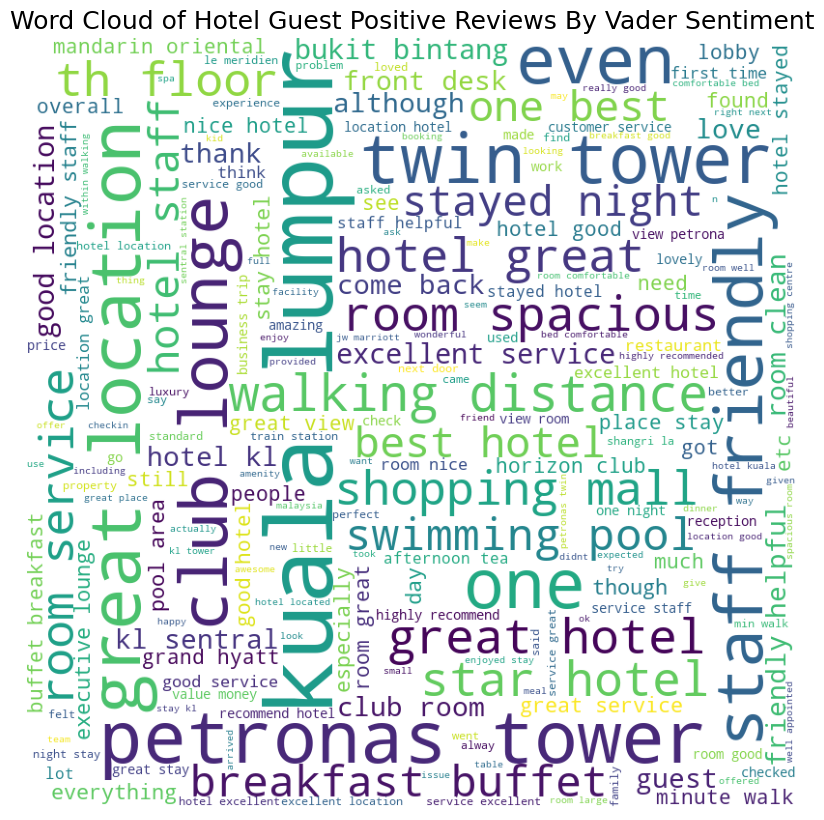

Time taken: 1.4070451259613037 seconds


In [180]:
# plot the WordCloud image for Guest Reviews
start_time = time.time()
plt.rcParams.update({'font.size': 15})
plt.figure(figsize = (8, 8), facecolor = None)
plt.imshow(wordcloud)
plt.axis("off")
plt.title('Word Cloud of Hotel Guest Positive Reviews By Vader Sentiment')
plt.tight_layout(pad = 0)
 
plt.show()

end_time = time.time()
time_taken = end_time - start_time
print(f"Time taken: {time_taken} seconds")

In [181]:
vader_negative = vader_dataset[vader_dataset["polarity_vader"]=="negative"]
vader_negative.shape

(2360, 23)

In [182]:
# plot the WordCloud image for Guest Reviews
start_time = time.time()
comment_words = ''
stopwords = set(STOPWORDS)
 
# iterate through the csv file
for val in vader_negative.review:
     
    # typecaste each val to string
    val = str(val)
 
    # split the value
    tokens = val.split()
     
    # Converts each token into lowercase
    for i in range(len(tokens)):
        tokens[i] = tokens[i].lower()
     
    comment_words += " ".join(tokens)+" "
 
wordcloud = WordCloud(width = 800, height = 800,
                background_color ='white',
                stopwords = stopwords,
                min_font_size = 10).generate(comment_words)
 
end_time = time.time()
time_taken = end_time - start_time
print(f"Time taken: {time_taken} seconds")

Time taken: 7.642394781112671 seconds


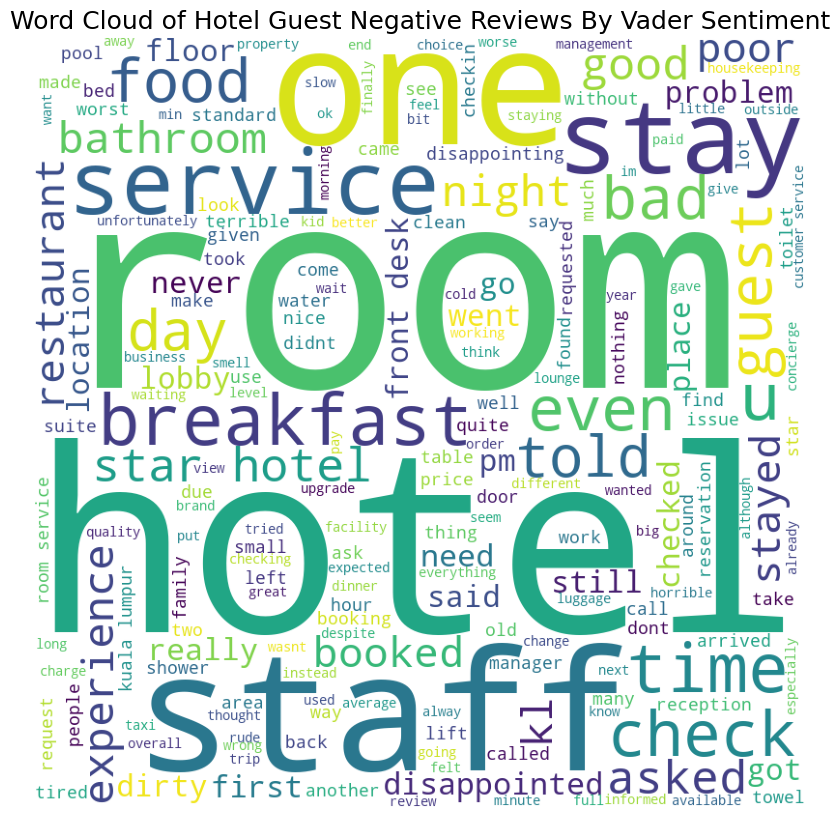

Time taken: 1.560410737991333 seconds


In [183]:
# plot the WordCloud image for Guest Reviews
start_time = time.time()
plt.rcParams.update({'font.size': 15})
plt.figure(figsize = (8, 8), facecolor = None)
plt.imshow(wordcloud)
plt.axis("off")
plt.title('Word Cloud of Hotel Guest Negative Reviews By Vader Sentiment')
plt.tight_layout(pad = 0)
 
plt.show()

end_time = time.time()
time_taken = end_time - start_time
print(f"Time taken: {time_taken} seconds")

## RoBERTa Pretrained Model

In [3]:
# ***** import roberta_dataset instead of re-run the code ***** skip the below code if the section
filename = 'roberta_dataset.csv' 

if os.path.exists(filename):
    roberta_dataset = pd.read_csv(filename)

In [184]:
#result_roberta to dataframe
start_time = time.time()
result_roberta_df = pd.DataFrame(result_roberta).T.reset_index().rename(columns={"index":"id"})
result_roberta_df

end_time = time.time()
time_taken = end_time - start_time
print(f"Time taken: {time_taken} seconds")

Time taken: 8.66064453125 seconds


In [185]:
result_roberta_df.sample(10)

id  roberta_neg  roberta_neu  roberta_pos
57487  58000     0.063750     0.814996     0.121253
50189  50236     0.002450     0.035053     0.962497
44473  44515     0.008202     0.086223     0.905575
53057  53569     0.010105     0.070099     0.919797
32273  32304     0.002372     0.065089     0.932539
56677  57189     0.004536     0.079619     0.915845
9224    9234     0.001618     0.010656     0.987726
58330  58845     0.010075     0.096398     0.893527
58995  59510     0.012528     0.044328     0.943144
13389  13402     0.025277     0.305381     0.669342

In [186]:
#merge roberta result with main dataset
roberta_dataset = pd.merge(result_roberta_df, dataset, how="left", on="id")
roberta_dataset

id  roberta_neg  roberta_neu  roberta_pos  \
0          1     0.001857     0.019607     0.978536   
1          2     0.006162     0.092213     0.901625   
2          3     0.004423     0.127536     0.868041   
3          4     0.001773     0.015458     0.982770   
4          5     0.002070     0.035389     0.962542   
...      ...          ...          ...          ...   
63547  64064     0.404215     0.566877     0.028908   
63548  64065     0.941764     0.054592     0.003644   
63549  64066     0.005703     0.135267     0.859030   
63550  64067     0.242889     0.489276     0.267835   
63551  64068     0.807813     0.182022     0.010164   

                         hotelname  comment_count  rating  rating_word  \
0                  EQ Kuala Lumpur            575     5.0            2   
1                  EQ Kuala Lumpur            575     5.0            2   
2                  EQ Kuala Lumpur            575     5.0            2   
3                  EQ Kuala Lumpur            575     5.0            2   
4                  EQ Kuala Lumpur            575     5.0            2   
...                            ...            ...     ...          ...   
63547  E&O Residences Kuala Lumpur            946     4.0            1   
63548  E&O Residences Kuala Lumpur            946     4.0            1   
63549  E&O Residences Kuala Lumpur            946     4.0            1   
63550  E&O Residences Kuala Lumpur            946     4.0            1   
63551  E&O Residences Kuala Lumpur            946     4.0            1   

       location_rating  cleanliness_rating  ...  value_rating  contributes  \
0                  5.0                 5.0  ...           5.0          0.0   
1                  5.0                 5.0  ...           5.0          0.0   
2                  5.0                 5.0  ...           5.0        105.0   
3                  5.0                 5.0  ...           5.0          0.0   
4                  5.0                 5.0  ...           5.0          0.0   
...                ...                 ...  ...           ...          ...   
63547              4.5                 4.0  ...           4.0          0.0   
63548              4.5                 4.0  ...           4.0          3.0   
63549              4.5                 4.0  ...           4.0         81.0   
63550              4.5                 4.0  ...           4.0       3726.0   
63551              4.5                 4.0  ...           4.0         58.0   

       helpfulvotes_guest  guest_rating_bubble  \
0                     0.0                  5.0   
1                     0.0                  5.0   
2                    78.0                  5.0   
3                     0.0                  5.0   
4                     0.0                  5.0   
...                   ...                  ...   
63547                 0.0                  1.0   
63548                 0.0                  1.0   
63549                43.0                  5.0   
63550               160.0                  3.0   
63551                20.0                  3.0   

                                                  review      dateofStay  \
0      lovely experience iconic eq kl hotel spent lov...    January 2023   
1      truly world class hotel stayed two night taken...    January 2023   
2      gem heart golden triangle eq kl gem unbeatable...    January 2023   
3      super location great hotel accommodating staff...   December 2022   
4      eq kl excellent service japanese restaurant co...    January 2023   
...                                                  ...             ...   
63547  الفندق غير جيد الفطور اقل من عادي طابور عند ال...     August 2017   
63548  worst ever worst hotel resident ever life sinc...       July 2017   
63549  nice hotel apartment time kuala lumpur favorit...      March 2017   
63550  hygiene review wont totally aligned term score...       July 2017   
63551  except space everything else average average f...       July 2017   

        g

In [187]:
def get_roberta_polarity(roberta_neg,roberta_pos,roberta_neu):
    diff_score = roberta_pos - roberta_neg
    combine_score = diff_score * (1 - roberta_neu)

    if combine_score >= 0.05:
        return 'positive'
    elif combine_score <= -0.05:
        return 'negative'
    else:
        return 'neutral'

In [188]:
roberta_dataset['polarity_roberta'] = roberta_dataset.apply(lambda roberta_dataset: get_roberta_polarity(roberta_dataset['roberta_neg'],roberta_dataset['roberta_pos'],roberta_dataset['roberta_neu']),axis=1)

In [189]:
roberta_dataset.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 63552 entries, 0 to 63551
Data columns (total 22 columns):
 #   Column               Non-Null Count  Dtype   
---  ------               --------------  -----   
 0   id                   63552 non-null  int64   
 1   roberta_neg          63552 non-null  float64 
 2   roberta_neu          63552 non-null  float64 
 3   roberta_pos          63552 non-null  float64 
 4   hotelname            63552 non-null  category
 5   comment_count        63552 non-null  int32   
 6   rating               63552 non-null  float64 
 7   rating_word          63552 non-null  int64   
 8   location_rating      63552 non-null  float64 
 9   cleanliness_rating   63552 non-null  float64 
 10  service_rating       63552 non-null  float64 
 11  value_rating         63552 non-null  float64 
 12  contributes          63552 non-null  float64 
 13  helpfulvotes_guest   63552 non-null  float64 
 14  guest_rating_bubble  63552 non-null  float64 
 15  review             

In [190]:
roberta_dataset.sample(5)

id  roberta_neg  roberta_neu  roberta_pos  \
32837  32868     0.001880     0.017262     0.980858   
20369  20392     0.013132     0.072863     0.914005   
32325  32356     0.001665     0.020764     0.977570   
15353  15369     0.001926     0.013406     0.984668   
44879  44921     0.003931     0.095905     0.900164   

                             hotelname  comment_count  rating  rating_word  \
32837  Mandarin Oriental, Kuala Lumpur           7269     4.5            2   
20369          Shangri-La Kuala Lumpur           8548     4.5            2   
32325  Mandarin Oriental, Kuala Lumpur           7269     4.5            2   
15353         Grand Hyatt Kuala Lumpur           5462     4.5            2   
44879   JW Marriott Hotel Kuala Lumpur           3536     4.5            2   

       location_rating  cleanliness_rating  ...  contributes  \
32837              5.0                 4.5  ...          1.0   
20369              4.5                 4.5  ...         42.0   
32325              5.0                 4.5  ...          3.0   
15353              5.0                 4.5  ...          1.0   
44879              5.0                 4.5  ...          6.0   

       helpfulvotes_guest  guest_rating_bubble  \
32837                 1.0                  5.0   
20369                 0.0                  5.0   
32325                 0.0                  5.0   
15353                 0.0                  5.0   
44879                 0.0                  5.0   

                                                  review       dateofStay  \
32837  excellent hotel excellent location beside conv...         May 2018   
20369  excellent hotel amazing hotel heart kuala lump...   September 2019   
32325  amazing stay amazing stay mandarin oriental kl...       March 2019   
15353  enjoyable stay went vacation kid love place es...       March 2022   
44879  perfect location shopping dining exquisite roo...   September 2019   

        guestCountry hotelname_encode dateofStay_encode  guestCountry_encode  \
32837      Indonesia               14            052018                   62   
20369  Not Mentioned               20            092019                  105   
32325  Not Mentioned               14            032019                  105   
15353  Not Mentioned                7            032022                  105   
44879  Not Mentioned               11            092019                  105   

      polarity_roberta  
32837         positive  
20369         positive  
32325         positive  
15353         positive  
44879         positive  

[5 rows x 22 columns]

In [194]:
roberta_dataset[["roberta_neg","roberta_neu","roberta_pos","polarity_roberta"]].sample(5)

roberta_neg  roberta_neu  roberta_pos polarity_roberta
11580     0.003547     0.077429     0.919024         positive
56417     0.002043     0.009727     0.988231         positive
1644      0.002357     0.016116     0.981527         positive
48697     0.128247     0.353720     0.518033         positive
55228     0.576567     0.343065     0.080369         negative

In [195]:
# BACKUP: export merged roberta dataset to csv
roberta_dataset.to_csv('roberta_dataset.csv',index=False)

In [196]:
roberta_dataset['polarity_roberta'].value_counts()

positive    58520
negative     3863
neutral      1169
Name: polarity_roberta, dtype: int64

In [197]:
roberta_positive = roberta_dataset[roberta_dataset["polarity_roberta"]=="positive"]
roberta_positive.shape

(58520, 22)

In [198]:
# plot the WordCloud image for Guest Reviews
start_time = time.time()
comment_words = ''
stopwords = set(STOPWORDS)
 
# iterate through the csv file
for val in roberta_positive.review:
     
    # typecaste each val to string
    val = str(val)
 
    # split the value
    tokens = val.split()
     
    # Converts each token into lowercase
    for i in range(len(tokens)):
        tokens[i] = tokens[i].lower()
     
    comment_words += " ".join(tokens)+" "
 
wordcloud = WordCloud(width = 800, height = 800,
                background_color ='white',
                stopwords = stopwords,
                min_font_size = 10).generate(comment_words)
 
end_time = time.time()
time_taken = end_time - start_time
print(f"Time taken: {time_taken} seconds")

Time taken: 157.65415811538696 seconds


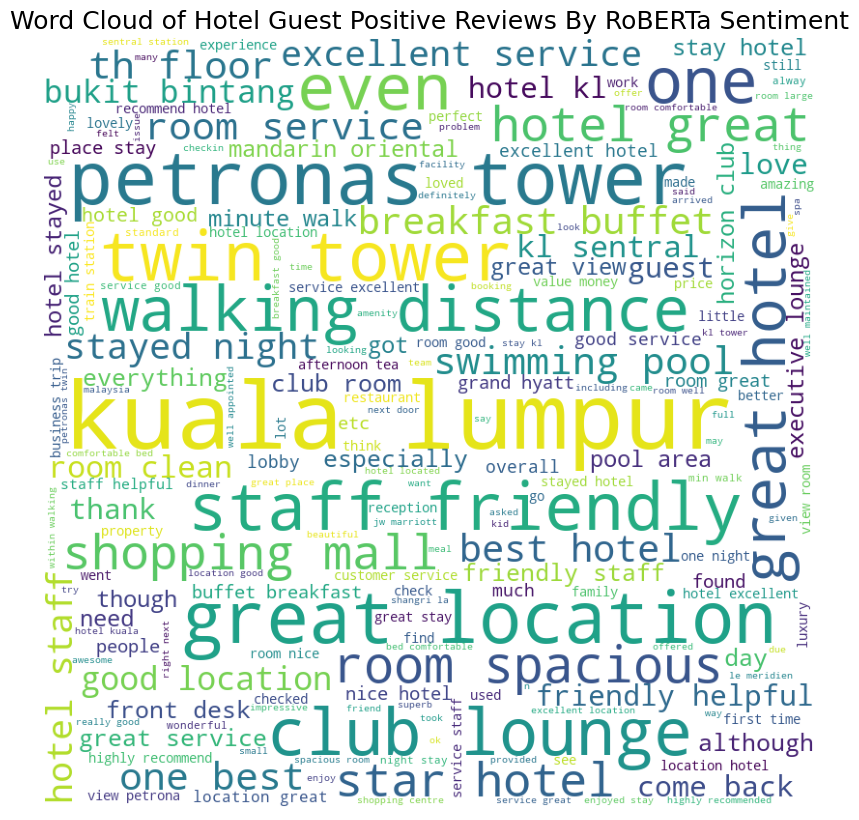

Time taken: 1.5416247844696045 seconds


In [199]:
# plot the WordCloud image for Guest Reviews
start_time = time.time()
plt.rcParams.update({'font.size': 15})
plt.figure(figsize = (8, 8), facecolor = None)
plt.imshow(wordcloud)
plt.axis("off")
plt.title('Word Cloud of Hotel Guest Positive Reviews By RoBERTa Sentiment')
plt.tight_layout(pad = 0)
 
plt.show()

end_time = time.time()
time_taken = end_time - start_time
print(f"Time taken: {time_taken} seconds")

In [200]:
roberta_negative = roberta_dataset[roberta_dataset["polarity_roberta"]=="negative"]
roberta_negative.shape

(3863, 22)

In [201]:
# plot the WordCloud image for Guest Reviews
start_time = time.time()
comment_words = ''
stopwords = set(STOPWORDS)
 
# iterate through the csv file
for val in roberta_negative.review:
     
    # typecaste each val to string
    val = str(val)
 
    # split the value
    tokens = val.split()
     
    # Converts each token into lowercase
    for i in range(len(tokens)):
        tokens[i] = tokens[i].lower()
     
    comment_words += " ".join(tokens)+" "
 
wordcloud = WordCloud(width = 800, height = 800,
                background_color ='white',
                stopwords = stopwords,
                min_font_size = 10).generate(comment_words)
 
end_time = time.time()
time_taken = end_time - start_time
print(f"Time taken: {time_taken} seconds")

Time taken: 8.291123628616333 seconds


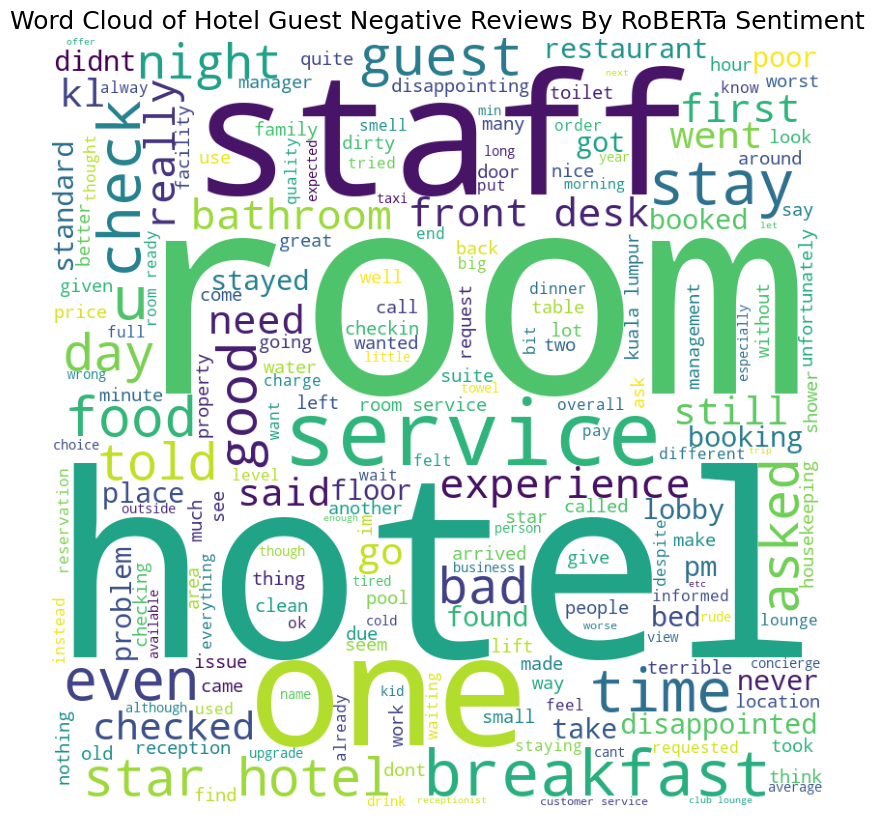

Time taken: 1.4338574409484863 seconds


In [202]:
# plot the WordCloud image for Guest Reviews
start_time = time.time()
plt.rcParams.update({'font.size': 15})
plt.figure(figsize = (8, 8), facecolor = None)
plt.imshow(wordcloud)
plt.axis("off")
plt.title('Word Cloud of Hotel Guest Negative Reviews By RoBERTa Sentiment')
plt.tight_layout(pad = 0)
 
plt.show()

end_time = time.time()
time_taken = end_time - start_time
print(f"Time taken: {time_taken} seconds")

## Preprocessed before modelling

### VADER

#### Correlation Matrix Heatmap

[Text(0, 0.5, 'id'),
 Text(0, 1.5, 'vader_neg'),
 Text(0, 2.5, 'vader_neu'),
 Text(0, 3.5, 'vader_pos'),
 Text(0, 4.5, 'vader_compound'),
 Text(0, 5.5, 'comment_count'),
 Text(0, 6.5, 'rating'),
 Text(0, 7.5, 'rating_word'),
 Text(0, 8.5, 'location_rating'),
 Text(0, 9.5, 'cleanliness_rating'),
 Text(0, 10.5, 'service_rating'),
 Text(0, 11.5, 'value_rating'),
 Text(0, 12.5, 'contributes'),
 Text(0, 13.5, 'helpfulvotes_guest'),
 Text(0, 14.5, 'guest_rating_bubble'),
 Text(0, 15.5, 'hotelname_encode'),
 Text(0, 16.5, 'dateofStay_encode'),
 Text(0, 17.5, 'guestCountry_encode')]

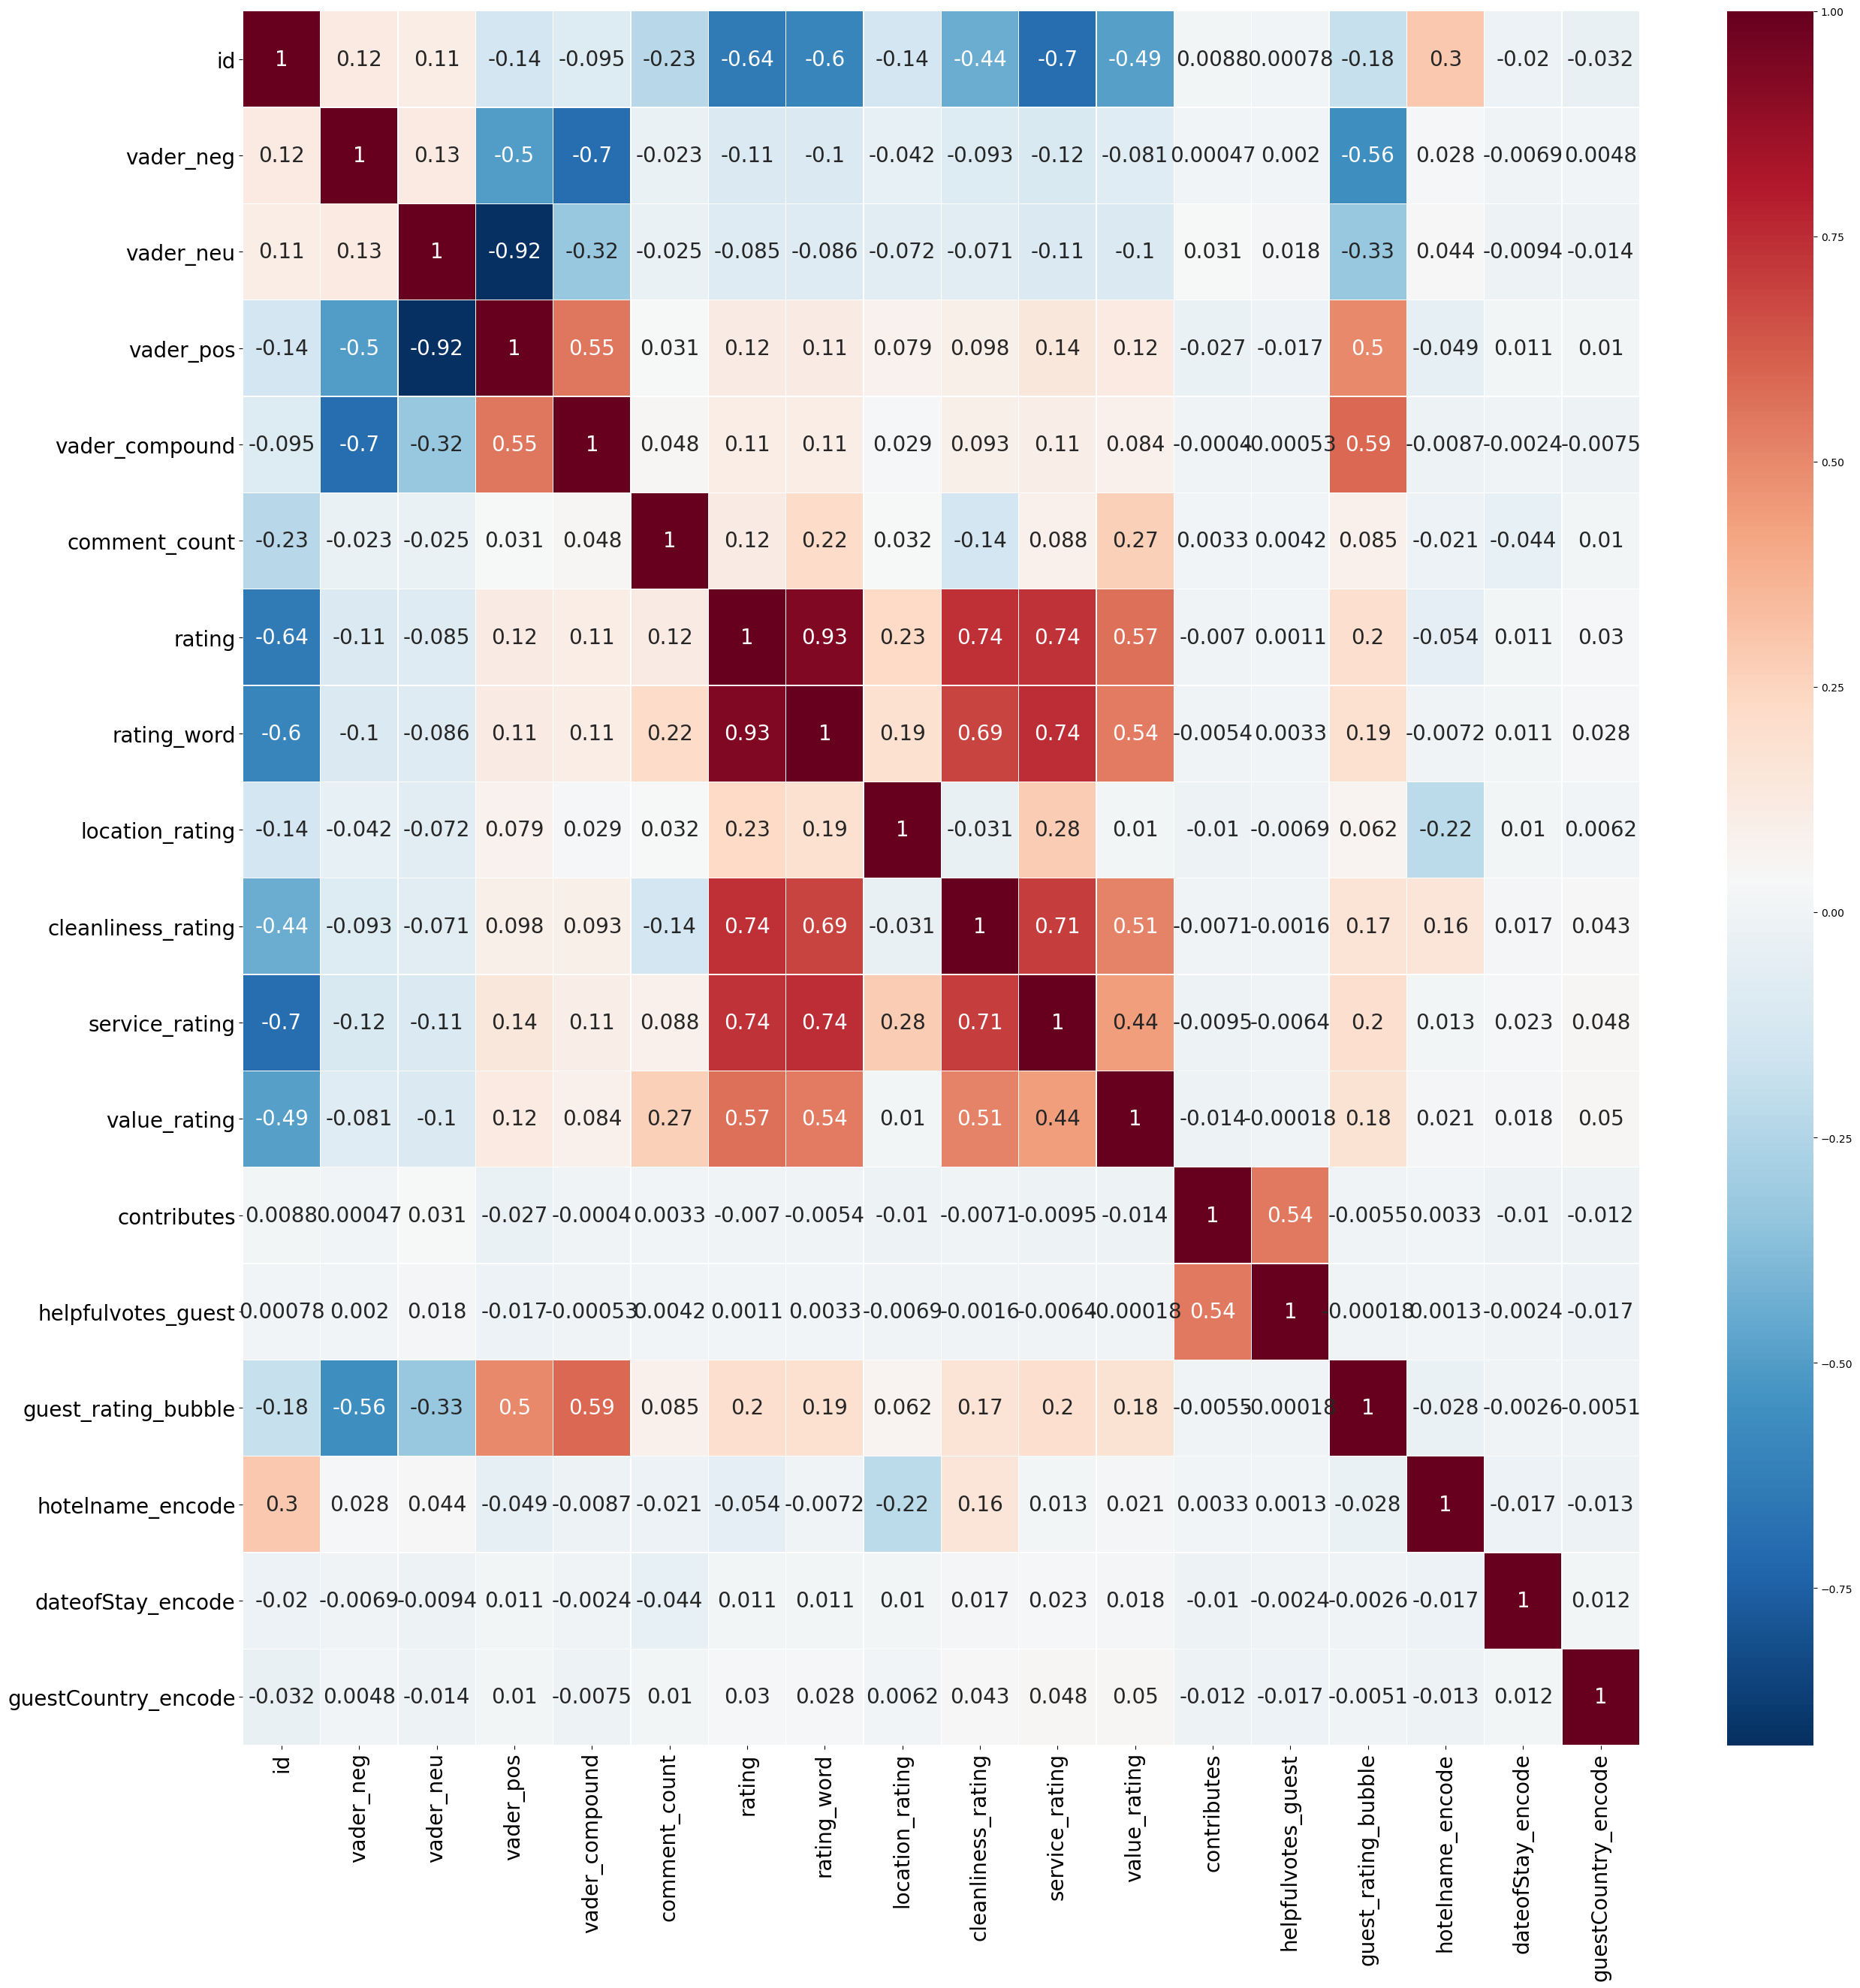

In [12]:
#Correlation Matrix Heatmap
pearsoncorr = vader_dataset.corr(method='pearson')
pearsoncorr = pearsoncorr[((pearsoncorr >= .5) | (pearsoncorr <= -.5)) & (pearsoncorr !=1.000)]
plt.figure(figsize=(30,30))
heatmap = sns.heatmap(vader_dataset.corr(method='pearson'), 
                xticklabels=pearsoncorr.columns,
                yticklabels=pearsoncorr.columns,
                cmap='RdBu_r',
                annot=True,
                linewidth=0.4,
                annot_kws={"fontsize":20})
heatmap.set_xticklabels(heatmap.get_xticklabels(), fontsize=20)
heatmap.set_yticklabels(heatmap.get_yticklabels(), fontsize=20)

#### Correlation Matrix Heatmap (Correlation > +-0.8)
To highlight the pairs of numerical variables which having correlation coefficient of more than 0.8 or -0.8.

Correlation > 0.8: 


rating         0.926565
rating_word    0.926565
vader_neu      0.924334
vader_pos      0.924334
dtype: float64

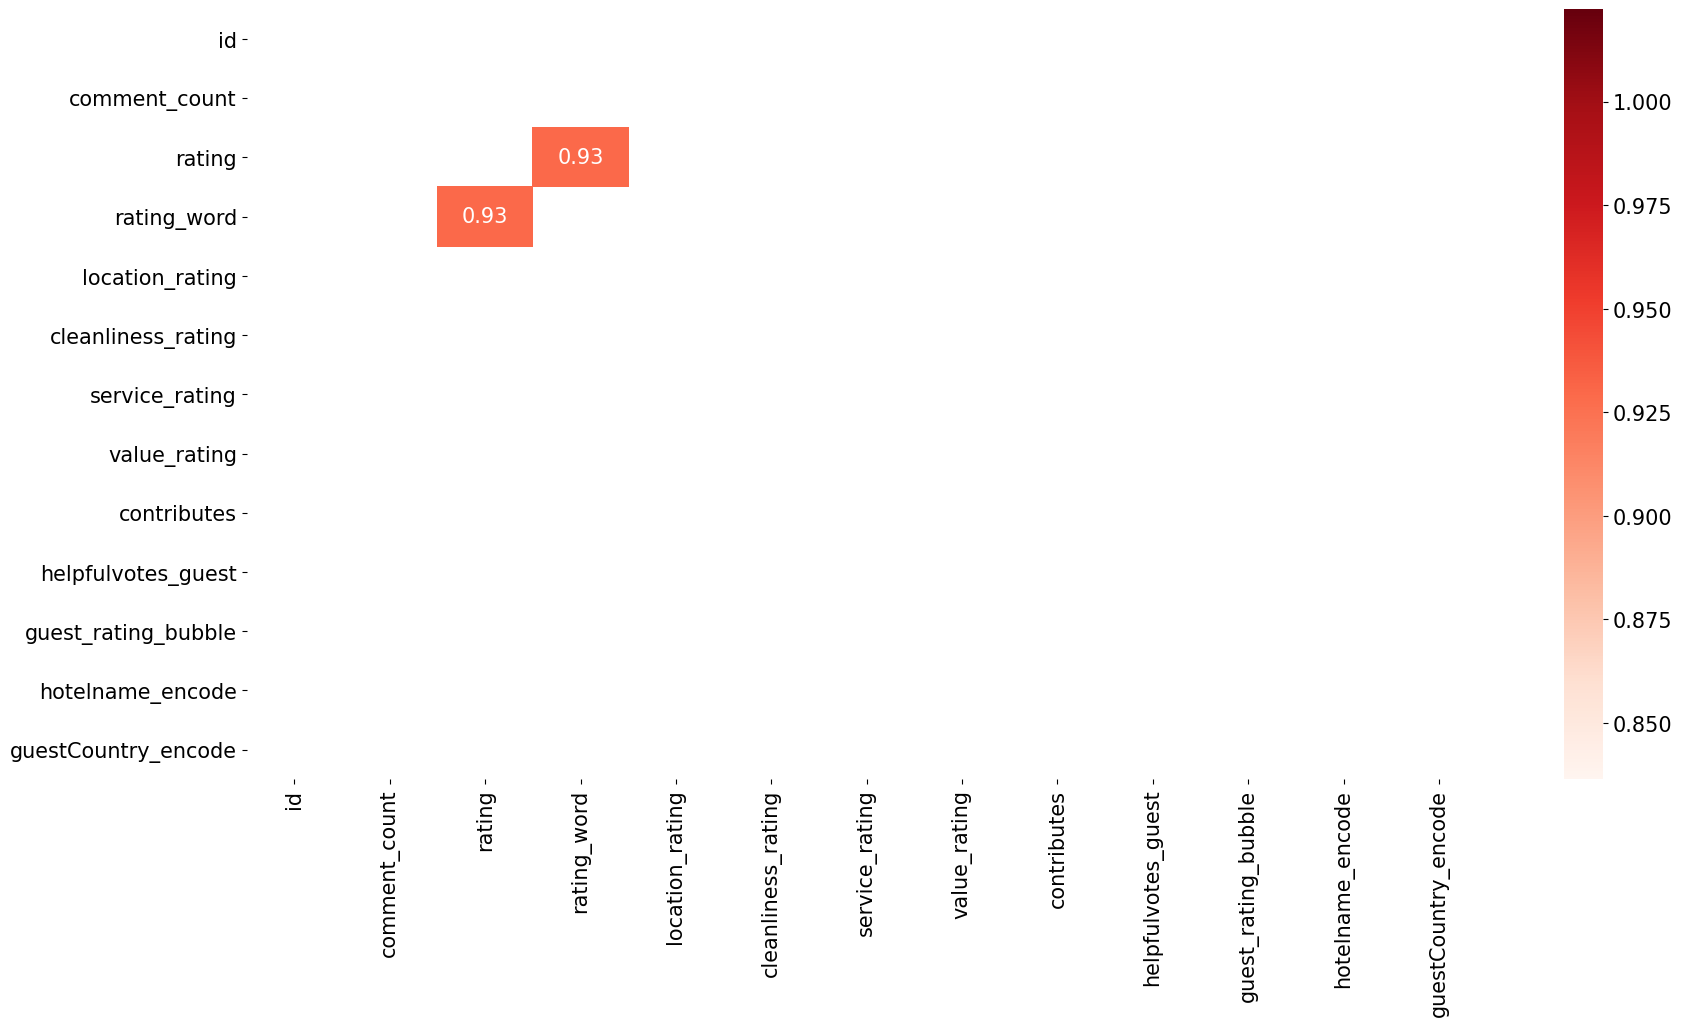

In [204]:
corr = vader_dataset.corr().abs()
corr[corr == 1] = 0
corr_cols = corr.max().sort_values(ascending=False)
print("Correlation > 0.8: ")
display(corr_cols[corr_cols > 0.8])

dfCorr = dataset.corr()
filteredDf = dfCorr[((dfCorr >= .8) | (dfCorr <= -.8)) & (dfCorr !=1.000)]
plt.figure(figsize=(20,10))
sns.heatmap(filteredDf, annot=True, cmap="Reds")
plt.show()

In [388]:
vader_dataset.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 63565 entries, 0 to 63564
Data columns (total 23 columns):
 #   Column               Non-Null Count  Dtype   
---  ------               --------------  -----   
 0   id                   63565 non-null  int64   
 1   vader_neg            63565 non-null  float64 
 2   vader_neu            63565 non-null  float64 
 3   vader_pos            63565 non-null  float64 
 4   vader_compound       63565 non-null  float64 
 5   hotelname            63565 non-null  category
 6   comment_count        63565 non-null  int32   
 7   rating               63565 non-null  float64 
 8   rating_word          63565 non-null  int64   
 9   location_rating      63565 non-null  float64 
 10  cleanliness_rating   63565 non-null  float64 
 11  service_rating       63565 non-null  float64 
 12  value_rating         63565 non-null  float64 
 13  contributes          63565 non-null  float64 
 14  helpfulvotes_guest   63565 non-null  float64 
 15  guest_rating_bubble

In [205]:
# drop["id","vader_neg","vader_neu","vader_pos","vader_compound","rating_word"]

vader_dataset_ml = vader_dataset[["hotelname_encode","comment_count","rating","location_rating","cleanliness_rating","service_rating","value_rating","contributes","helpfulvotes_guest","guest_rating_bubble","dateofStay_encode","guestCountry_encode","polarity_vader"]]

In [206]:
vader_dataset_ml.sample(5)

hotelname_encode  comment_count  rating  location_rating  \
61794                 8           2990     4.0              5.0   
29599                10           3844     4.5              4.5   
48077                24           3523     4.5              4.0   
23419                20           8548     4.5              4.5   
18139                 7           5462     4.5              5.0   

       cleanliness_rating  service_rating  value_rating  contributes  \
61794                 4.0             4.0           4.0          2.0   
29599                 4.5             4.5           4.0         13.0   
48077                 5.0             4.5           4.5        340.0   
23419                 4.5             4.5           4.5          2.0   
18139                 4.5             4.5           4.5         37.0   

       helpfulvotes_guest  guest_rating_bubble dateofStay_encode  \
61794                 0.0                  4.0            032017   
29599                21.0                  4.0            052016   
48077               141.0                  5.0            092019   
23419                 0.0                  5.0            032015   
18139                20.0                  5.0            052016   

       guestCountry_encode polarity_vader  
61794                  105       positive  
29599                  123       positive  
48077                  142       positive  
23419                  105       positive  
18139                   62       positive

### BACKUP: export to vader_dataset_ml.csv

In [207]:
#export preprocessed vader_dataset to csv, ready for modelling
vader_dataset_ml.to_csv('vader_dataset_ml.csv',index=False)

In [174]:
# ***** import vader_dataset_ml instead of re-run the code ***** 
filename = 'vader_dataset_ml.csv' 

if os.path.exists(filename):
    vader_dataset_ml = pd.read_csv(filename)

### RoBERTa

[Text(0, 0.5, 'id'),
 Text(0, 1.5, 'roberta_neg'),
 Text(0, 2.5, 'roberta_neu'),
 Text(0, 3.5, 'roberta_pos'),
 Text(0, 4.5, 'comment_count'),
 Text(0, 5.5, 'rating'),
 Text(0, 6.5, 'rating_word'),
 Text(0, 7.5, 'location_rating'),
 Text(0, 8.5, 'cleanliness_rating'),
 Text(0, 9.5, 'service_rating'),
 Text(0, 10.5, 'value_rating'),
 Text(0, 11.5, 'contributes'),
 Text(0, 12.5, 'helpfulvotes_guest'),
 Text(0, 13.5, 'guest_rating_bubble'),
 Text(0, 14.5, 'hotelname_encode'),
 Text(0, 15.5, 'dateofStay_encode'),
 Text(0, 16.5, 'guestCountry_encode')]

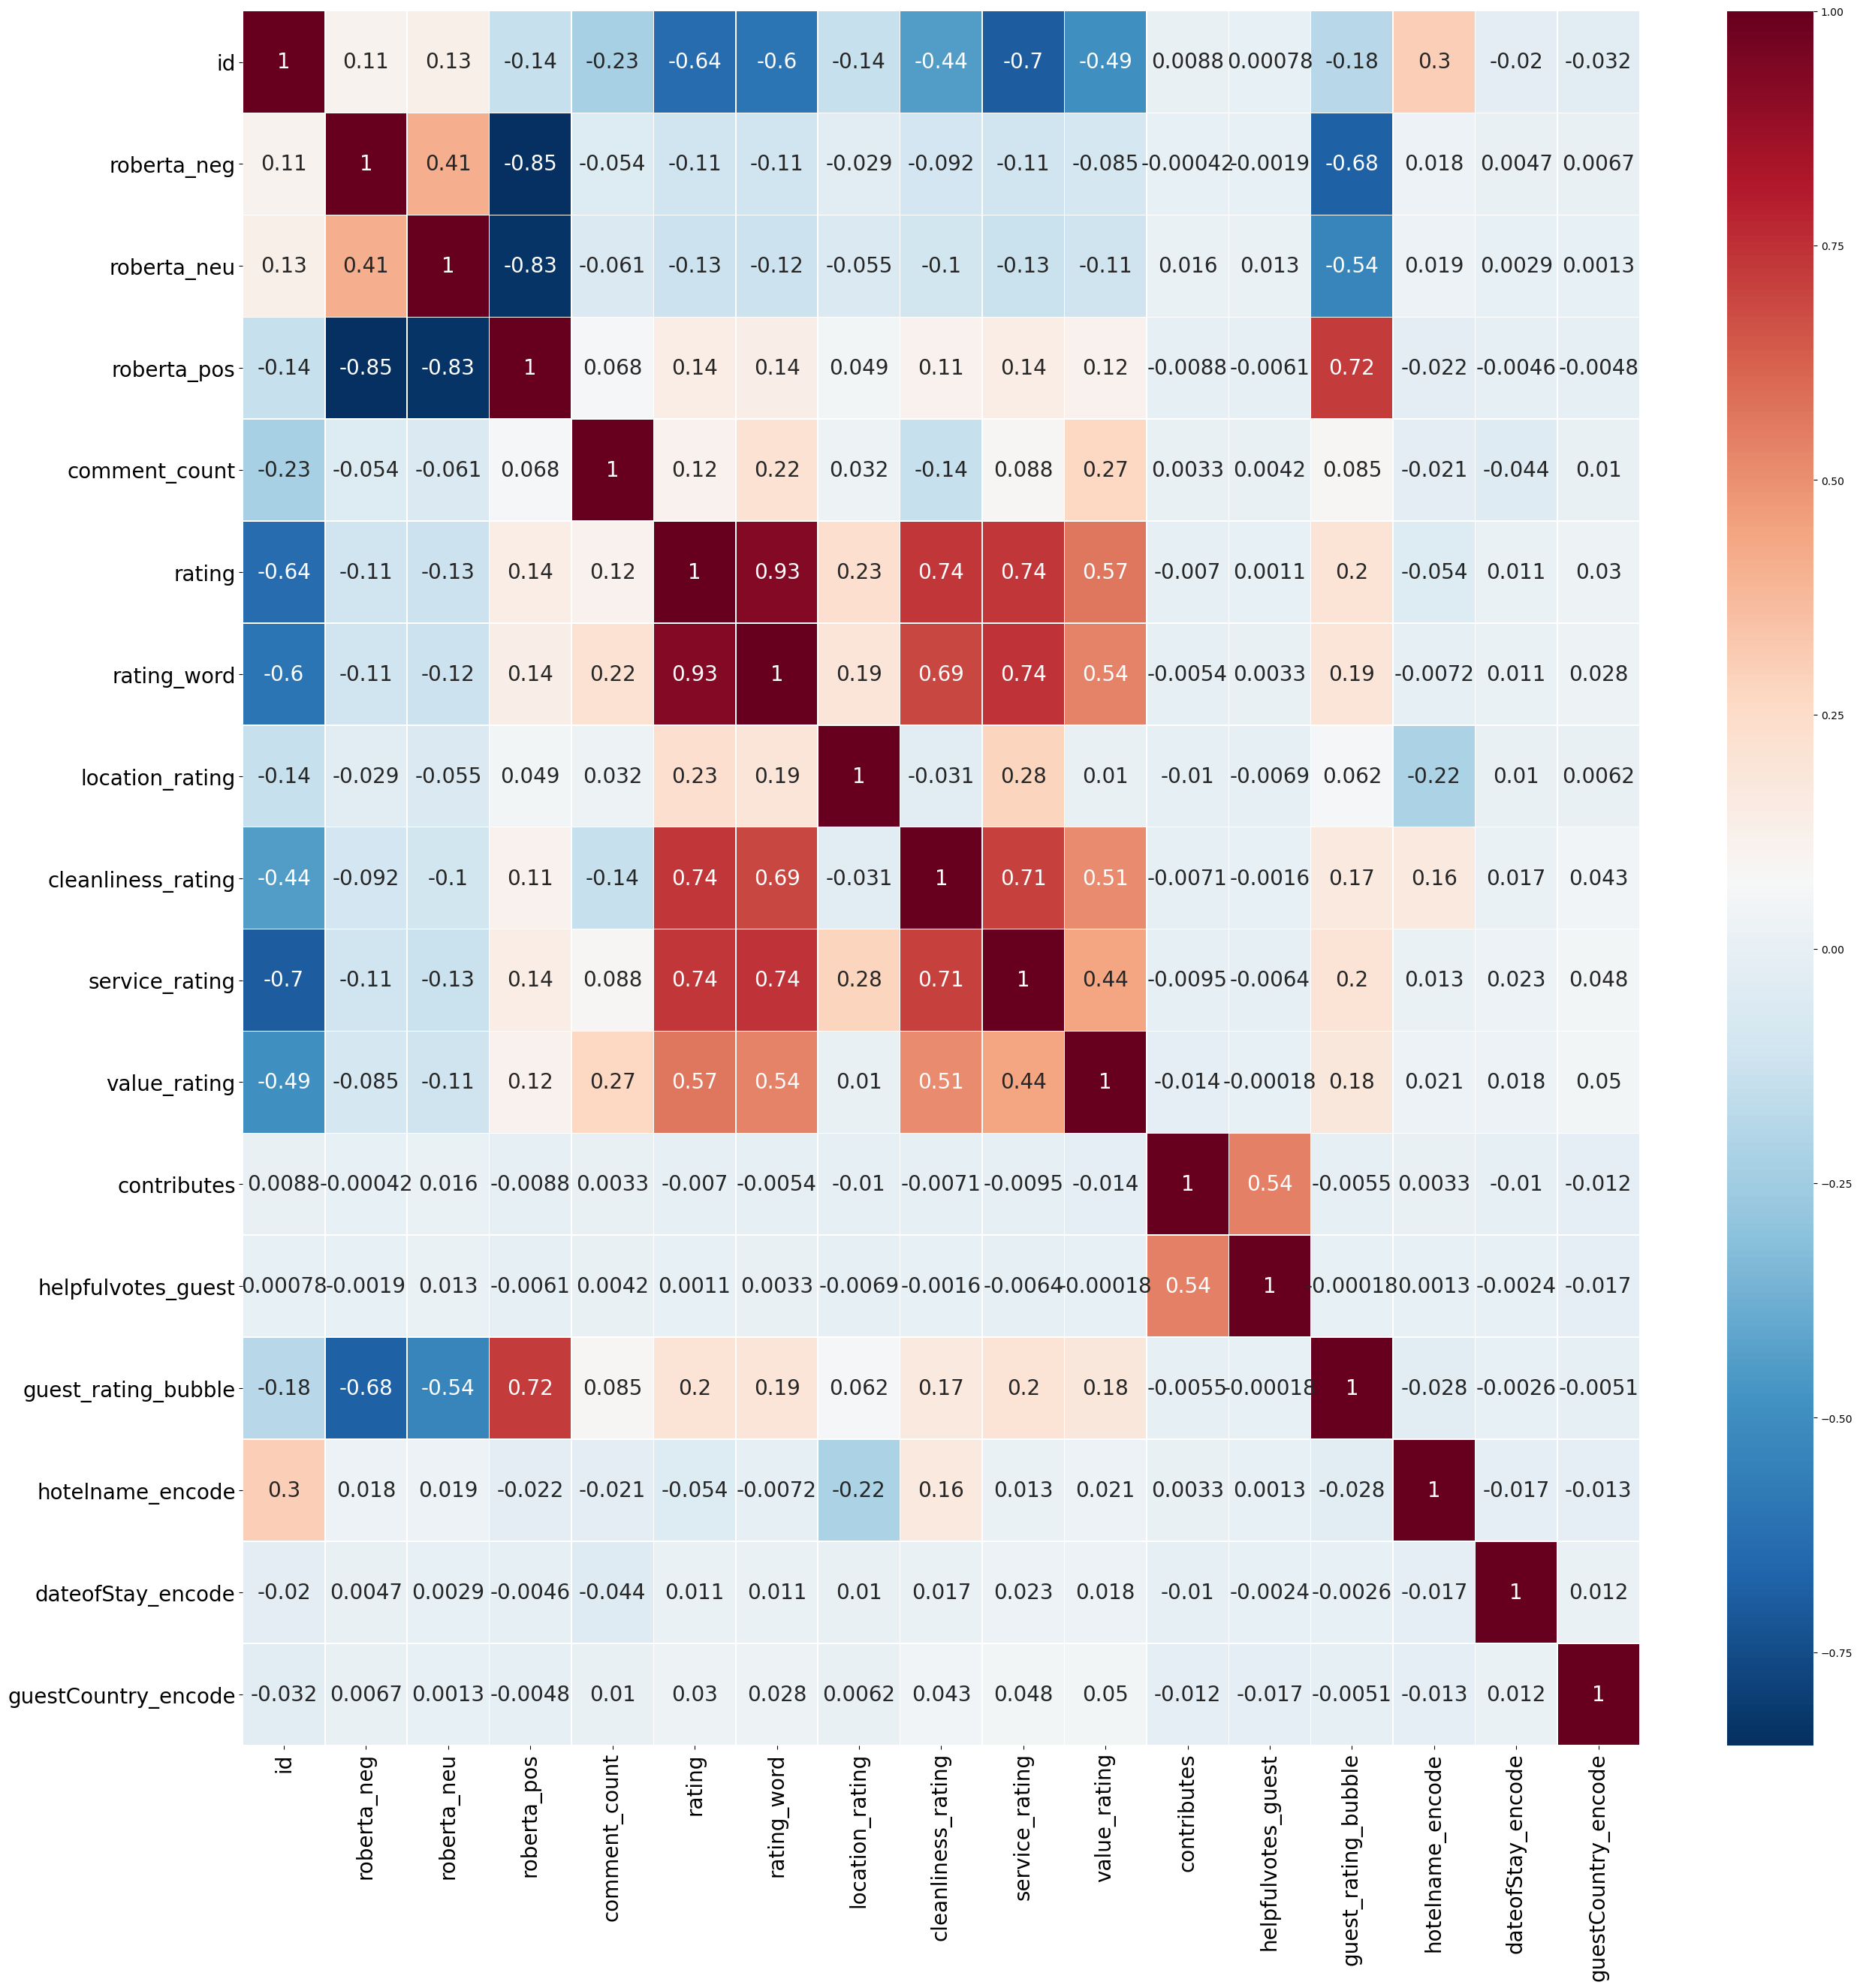

In [11]:
#Correlation Matrix Heatmap
pearsoncorr = roberta_dataset.corr(method='pearson')
pearsoncorr = pearsoncorr[((pearsoncorr >= .5) | (pearsoncorr <= -.5)) & (pearsoncorr !=1.000)]
plt.figure(figsize=(30,30))
heatmap = sns.heatmap(roberta_dataset.corr(method='pearson'), 
                    xticklabels=pearsoncorr.columns,
                    yticklabels=pearsoncorr.columns,
                    cmap='RdBu_r',
                    annot=True,
                    linewidth=0.4,
                    annot_kws={"fontsize":20})
heatmap.set_xticklabels(heatmap.get_xticklabels(), fontsize=20)
heatmap.set_yticklabels(heatmap.get_yticklabels(), fontsize=20)

#### Correlation Matrix Heatmap (Correlation > +-0.8)
To highlight the pairs of numerical variables which having correlation coefficient of more than 0.8 or -0.8.

Correlation > 0.8: 


rating         0.926565
rating_word    0.926565
roberta_neg    0.849250
roberta_pos    0.849250
roberta_neu    0.830650
dtype: float64

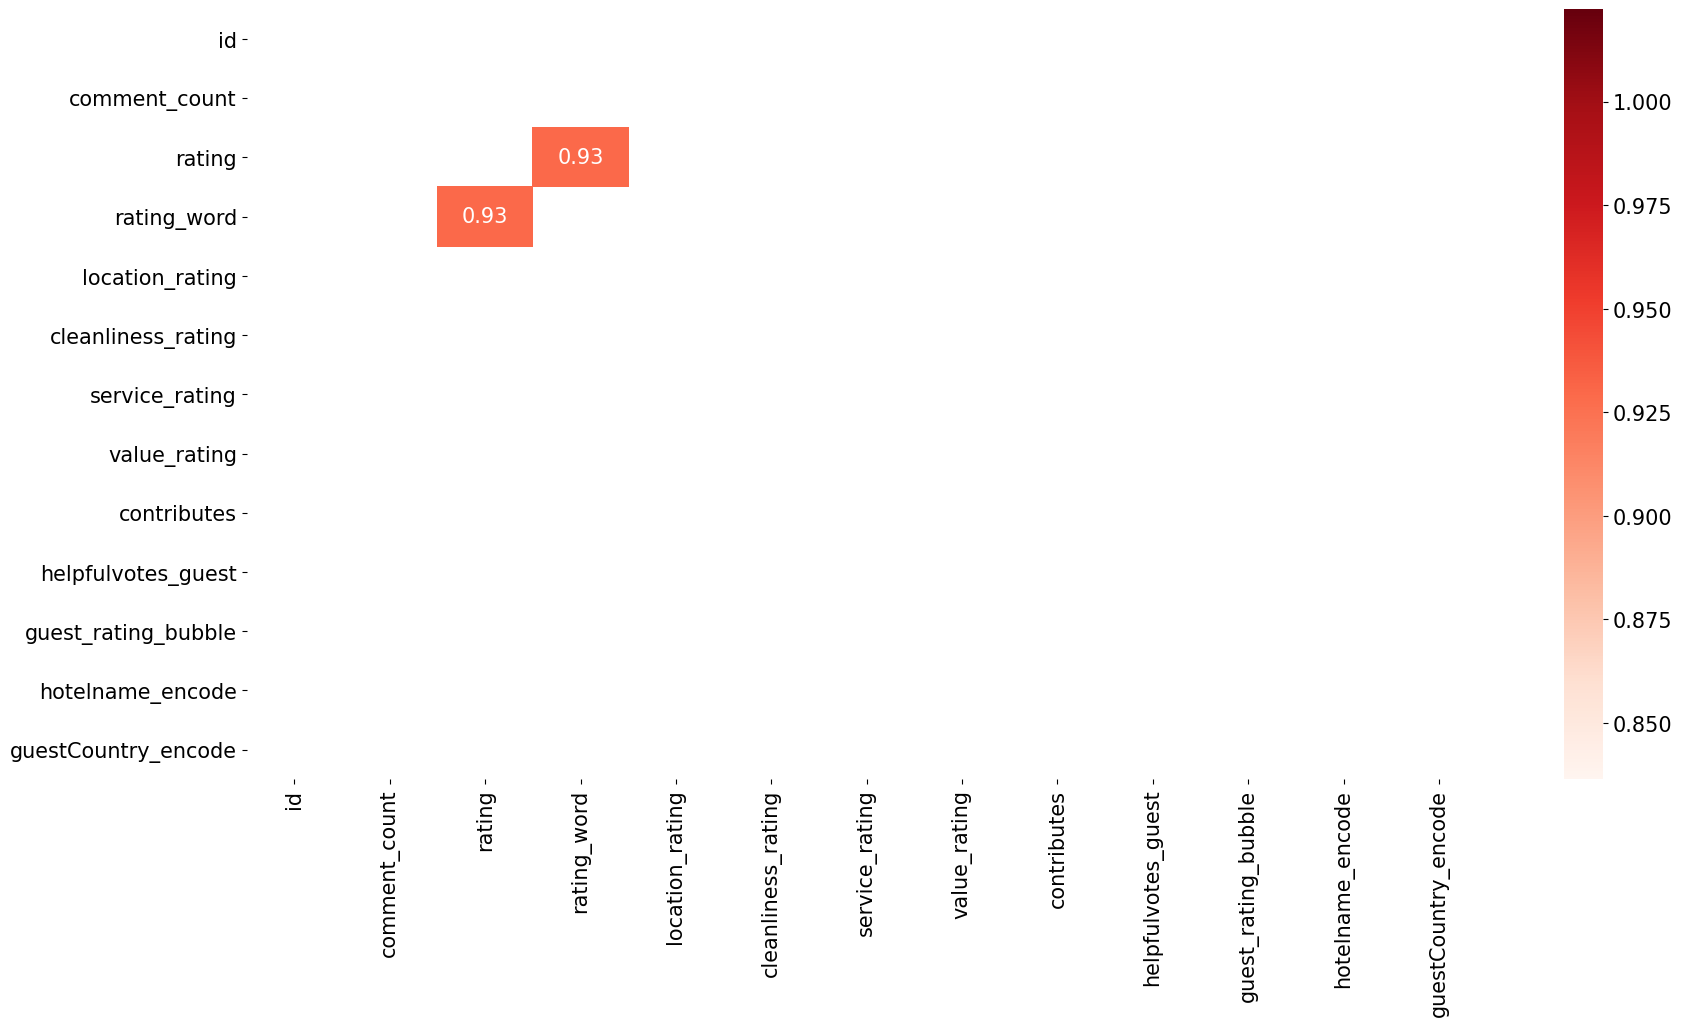

In [209]:
corr = roberta_dataset.corr().abs()
corr[corr == 1] = 0
corr_cols = corr.max().sort_values(ascending=False)
print("Correlation > 0.8: ")
display(corr_cols[corr_cols > 0.8])

dfCorr = dataset.corr()
filteredDf = dfCorr[((dfCorr >= .8) | (dfCorr <= -.8)) & (dfCorr !=1.000)]
plt.figure(figsize=(20,10))
sns.heatmap(filteredDf, annot=True, cmap="Reds")
plt.show()

In [394]:
roberta_dataset.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 63565 entries, 0 to 63564
Data columns (total 22 columns):
 #   Column               Non-Null Count  Dtype   
---  ------               --------------  -----   
 0   id                   63565 non-null  int64   
 1   roberta_neg          63565 non-null  float64 
 2   roberta_neu          63565 non-null  float64 
 3   roberta_pos          63565 non-null  float64 
 4   hotelname            63565 non-null  category
 5   comment_count        63565 non-null  int32   
 6   rating               63565 non-null  float64 
 7   rating_word          63565 non-null  int64   
 8   location_rating      63565 non-null  float64 
 9   cleanliness_rating   63565 non-null  float64 
 10  service_rating       63565 non-null  float64 
 11  value_rating         63565 non-null  float64 
 12  contributes          63565 non-null  float64 
 13  helpfulvotes_guest   63565 non-null  float64 
 14  guest_rating_bubble  63565 non-null  int64   
 15  review             

In [210]:
# drop["id","roberta_neg","roberta_neu","roberta_pos","rating_word"]

roberta_dataset_ml = roberta_dataset[["hotelname_encode","comment_count","rating","location_rating","cleanliness_rating","service_rating","value_rating","contributes","helpfulvotes_guest","guest_rating_bubble","dateofStay_encode","guestCountry_encode","polarity_roberta"]]

In [211]:
roberta_dataset_ml.sample(5)

hotelname_encode  comment_count  rating  location_rating  \
36984                14           7269     4.5              5.0   
8131                  6           1073     4.5              5.0   
49461                24           3523     4.5              4.0   
53527                18           4687     4.0              4.5   
593                  12           1064     5.0              5.0   

       cleanliness_rating  service_rating  value_rating  contributes  \
36984                 4.5             4.5           4.5          5.0   
8131                  5.0             4.5           4.5         10.0   
49461                 5.0             4.5           4.5          5.0   
53527                 4.0             4.0           4.0          0.0   
593                   5.0             4.5           4.5        112.0   

       helpfulvotes_guest  guest_rating_bubble dateofStay_encode  \
36984                12.0                  5.0            112008   
8131                  0.0                  5.0            082020   
49461                 0.0                  5.0            102016   
53527                 0.0                  3.0            032019   
593                  78.0                  5.0            052022   

       guestCountry_encode polarity_roberta  
36984                  105         positive  
8131                   105         positive  
49461                  105         positive  
53527                  105         positive  
593                    101         positive

### BACKUP: export to roberta_dataset_ml.csv

In [212]:
#export preprocessed roberta_dataset to csv, ready for modelling
roberta_dataset_ml.to_csv('roberta_dataset_ml.csv',index=False)

In [174]:
# ***** import roberta_dataset_ml instead of re-run the code ***** 
filename = 'roberta_dataset_ml.csv' 

if os.path.exists(filename):
    roberta_dataset_ml = pd.read_csv(filename)

## Modelling - go to Modelling.ipynb

# REFERENCES

In [1]:
@inproceedings{camacho-collados-etal-2022-tweetnlp,
    title={{T}weet{NLP}: {C}utting-{E}dge {N}atural {L}anguage {P}rocessing for {S}ocial {M}edia},
    author={Camacho-Collados, Jose and Rezaee, Kiamehr and Riahi, Talayeh and Ushio, Asahi and Loureiro, Daniel and Antypas, Dimosthenis and Boisson, Joanne and Espinosa-Anke, Luis and Liu, Fangyu and Mart{\'\i}nez-C{\'a}mara, Eugenio and others},
    author = "Ushio, Asahi  and
      Camacho-Collados, Jose",
    booktitle = "Proceedings of the 2022 Conference on Empirical Methods in Natural Language Processing: System Demonstrations",
    month = nov,
    year = "2022",
    address = "Abu Dhabi, U.A.E.",
    publisher = "Association for Computational Linguistics",
}

SyntaxError: invalid syntax (567781068.py, line 1)